In [2]:
%matplotlib inline

import datetime
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

import tensorflow as tf

# How to enable Colab GPUs https://colab.research.google.com/notebooks/gpu.ipynb
# Select the Runtime > "Change runtime type" menu to enable a GPU accelerator,
# and then re-execute this cell.
if 'google.colab' in str(get_ipython()):
    device_name = tf.test.gpu_device_name()
    if device_name != '/device:GPU:0':
        raise SystemError('GPU device not found')
    print('Found GPU at: {}'.format(device_name))

import tensorflow.keras as keras
from keras.models import Sequential
from keras.layers import Input, InputLayer, Dense, Dropout, Activation, Conv1D, \
                         BatchNormalization, GlobalAveragePooling1D, Flatten, \
                         Reshape, LSTM  # TODO Remove unused elements
from tensorflow.keras.optimizers import Adam # - Works
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Reduces variance in results but won't eliminate it :-(
%env PYTHONHASHSEED=0
import random
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

Found GPU at: /device:GPU:0
env: PYTHONHASHSEED=0


# LSTM Networks for Cambridge UK Weather Time Series

LSTM models for time series analysis of Cambridge UK temperature measurements taken at the [University computer lab weather station](https://www.cl.cam.ac.uk/research/dtg/weather/).

This notebook is being developed on [Google Colab](https://colab.research.google.com), primarily using [keras/tensorflow](https://www.tensorflow.org/guide/keras/sequential_model).  I'm most interested in short term temperature forecasts (less than 2 hours) but will include results up to 48 hours in the future for comparison with earlier [baselines](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/main/notebooks/cammet_baselines_2021.ipynb).

See my previous work for further details:
 * [Cambridge UK temperature forecast python notebooks](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks)
 * [Cambridge UK temperature forecast R models](https://github.com/makeyourownmaker/CambridgeTemperatureModel)
 * [Bayesian optimisation of prophet temperature model](https://github.com/makeyourownmaker/BayesianProphet)
 * [Cambridge University Computer Laboratory weather station R shiny web app](https://github.com/makeyourownmaker/ComLabWeatherShiny)

In particular, see the [keras_mlp_fcn_resnet_time_series notebook](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/main/notebooks/keras_mlp_fcn_resnet_time_series.ipynb), which uses a streamlined version of data preparation from [Tensorflow time series forecasting tutorial](https://www.tensorflow.org/tutorials/structured_data/time_series).  That notebook showed promising results for LSTM networks.

Most of the above repositories, notebooks, web apps etc were built on both less data and less thoroughly cleaned data.

## Import Data

The measurements are relatively noisy and there are usually several hundred missing values every year; often across multiple variables.
Observations have been extensively cleaned but may still have issues.  Interpolation and missing value imputation have been used to fill all missing values.  See the [cleaning section](https://github.com/makeyourownmaker/CambridgeTemperatureModel#Cleaning) in the [Cambridge Temperature Model repository](https://github.com/makeyourownmaker/CambridgeTemperatureModel) for details.  Observations start in August 2008 and end in April 2021 and occur every 30 mins.

Shape:
(223250, 7)

Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 223250 entries, 2008-08-01 00:30:00 to 2021-04-26 01:00:00
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   ds                 223250 non-null  datetime64[ns]
 1   y                  223250 non-null  float64       
 2   humidity           223250 non-null  float64       
 3   dew.point          223250 non-null  float64       
 4   pressure           223250 non-null  float64       
 5   wind.speed.mean    223250 non-null  float64       
 6   wind.bearing.mean  223250 non-null  float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 13.6 MB
None

Summary stats:


,y,humidity,dew.point,pressure,wind.speed.mean,wind.bearing.mean
count,223250.000000,223250.000000,223250.000000,223250.000000,223250.000000,223250.000000
mean,10.000512,78.689959,58.880634,1014.336135,4.432390,195.051399
std,6.496255,17.274417,51.630120,11.935364,4.013553,82.881764
min,-7.000000,20.000000,-100.000000,963.000000,0.000000,0.000000
25%,5.200000,68.000000,20.000000,1008.000000,1.200000,135.000000
50%,9.600000,83.000000,60.000000,1016.000000,3.500000,225.000000
75%,14.500000,92.000000,97.000000,1022.000000,6.600000,270.000000
max,36.100000,100.000000,209.000000,1051.000000,29.200000,360.000000



Raw data:


,ds,y,humidity,dew.point,pressure,wind.speed.mean,wind.bearing.mean
ds,,,,,,,
2008-08-01 00:30:00,2008-08-01 00:30:00,19.5,65.75000,119.150000,1014.416667,1.150000,225.0
2008-08-01 01:00:00,2008-08-01 01:00:00,19.1,49.75000,79.200000,1014.384615,1.461538,225.0
2008-08-01 01:30:00,2008-08-01 01:30:00,19.1,66.17875,106.600000,1014.500000,1.508333,225.0
2008-08-01 02:00:00,2008-08-01 02:00:00,19.1,58.50000,99.250000,1014.076923,1.430769,225.0
2008-08-01 02:30:00,2008-08-01 02:30:00,19.1,66.95000,121.883333,1014.416667,1.133333,225.0
...,...,...,...,...,...,...,...
2021-04-25 23:00:00,2021-04-25 23:00:00,3.6,61.00000,-32.000000,1028.000000,1.400000,45.0
2021-04-25 23:30:00,2021-04-25 23:30:00,3.6,64.00000,-26.000000,1028.000000,2.600000,45.0
2021-04-26 00:00:00,2021-04-26 00:00:00,3.6,58.00000,-39.000000,1028.000000,4.300000,45.0


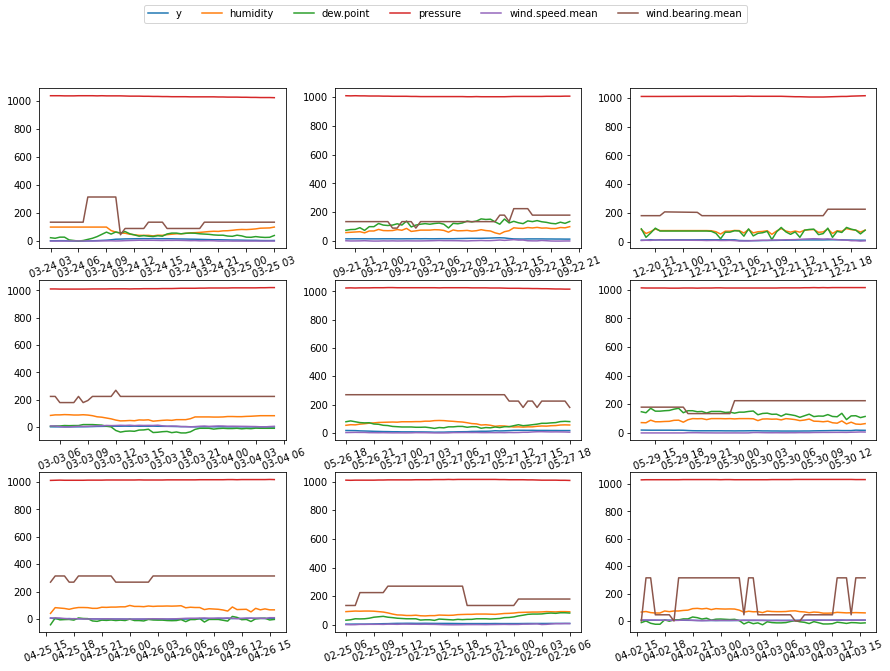

In [3]:
if 'google.colab' in str(get_ipython()):
    data_loc = "https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/main/data/CamMetCleanish2021.04.26.csv?raw=true"
else:
    data_loc = "../data/CamMetCleanish2021.04.26.csv"
df = pd.read_csv(data_loc, parse_dates = True)

df['ds'] = pd.to_datetime(df['ds'])
df.set_index(df['ds'], drop = False, inplace = True)
df = df[~df.index.duplicated(keep = 'first')]

df['y'] = df['y'] / 10
df['wind.speed.mean'] = df['wind.speed.mean'] / 10

# df = df.loc[df['ds'] < '2020-01-01 00:00:00',]  # exclude latest data for comparison purposes
df = df.loc[df['ds'] > '2008-08-01 00:00:00',]
df_orig = df

print("Shape:")
print(df.shape)
print("\nInfo:")
print(df.info())
print("\nSummary stats:")
display(df.describe())
print("\nRaw data:")
display(df)
print("\n")


def plot_examples(data, x_var):
    """Plot 9 sets of observations in 3 * 3 matrix ..."""

    assert len(data) == 9

    cols = [col for col in data[0].columns if col != x_var]

    fig, axs = plt.subplots(3, 3, figsize = (15, 10))
    axs = axs.ravel()  # apl for the win :-)

    for i in range(9):
      for col in cols:
        axs[i].plot(data[i][x_var], data[i][col])
        axs[i].xaxis.set_tick_params(rotation = 20, labelsize = 10)
    
    fig.legend(cols, loc = 'upper center',  ncol = len(cols))
    
    return None


cols = ['ds', 'y', 'humidity', 'dew.point', 'pressure', 
        'wind.speed.mean', 'wind.bearing.mean']
ex_plots = 9
hour_window = 24
starts = df.sample(n = ex_plots).index
p_data = [df.loc[starts[i]:starts[i] + datetime.timedelta(hours = hour_window), cols] 
          for i in range(ex_plots)]
plot_examples(p_data, 'ds')



---

## Data Processing and Feature Engineering

The data must be reformatted before model building.

The following steps are carried out:

 * Wind direction and speed transformation
 * Time conversion
 * tbats seasonal components addition
 * Train test data separation
 * Data normalisation
 * Data windowing

### Wind direction and speed transformation

The `wind.bearing.mean` column gives wind direction in degrees but is  categorised at 45 degree increments, i.e. 0, 45, 90, 135, 180, 225, 270, 315. Wind direction shouldn't matter if the wind is not blowing.

The distribution of wind direction and speed looks like this:

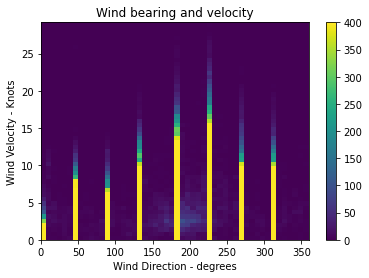

In [4]:
plt.hist2d(df['wind.bearing.mean'], df['wind.speed.mean'], bins = (50, 50), vmax = 400)
plt.colorbar()
plt.xlabel('Wind Direction - degrees')
plt.ylabel('Wind Velocity - Knots')
plt.title('Wind bearing and velocity');

Convert wind direction and speed to x and y vectors, so the model can more easily interpret them.

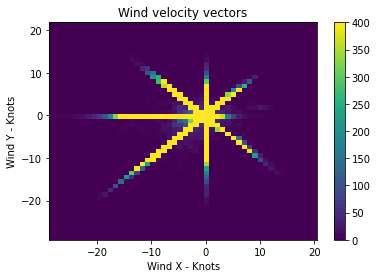

In [5]:
wv = df['wind.speed.mean']

# Convert to radians
wd_rad = df['wind.bearing.mean'] * np.pi / 180

# Calculate the wind x and y components
df['wind.x'] = wv * np.cos(wd_rad)
df['wind.y'] = wv * np.sin(wd_rad)

df_orig = df

plt.hist2d(df['wind.x'], df['wind.y'], bins = (50, 50), vmax = 400)
plt.colorbar()
plt.xlabel('Wind X - Knots')
plt.ylabel('Wind Y - Knots')
plt.title('Wind velocity vectors');


Wind velocity vectors are better, but are still clustered around the 45 degree increments. Data augmentation with the [mixup method](https://arxiv.org/abs/1710.09412) is carried out to counter this clustering.

From the [mixup paper](https://arxiv.org/abs/1710.09412): "mixup trains a neural network on convex combinations of pairs of examples and their labels".

Further details on how I apply mixup to time series are included in the Window data section of my [keras_mlp_fcn_resnet_time_series notebook](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/main/notebooks/keras_mlp_fcn_resnet_time_series.ipynb).

Here is an illustration of the improvement in wind velocity sparsity with mixup augmentation.

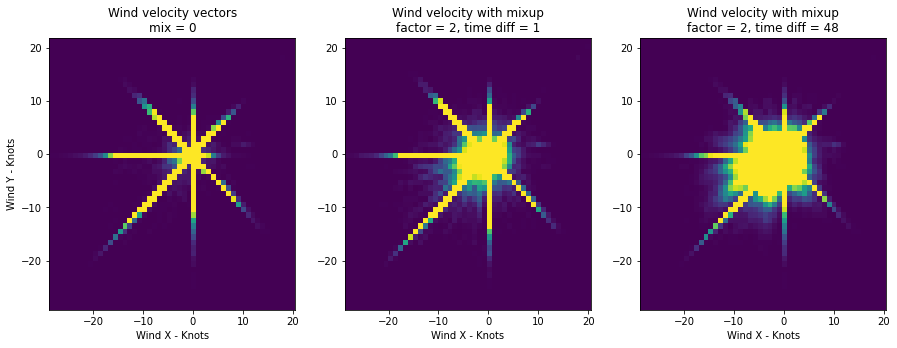

In [6]:
def mixup(data, alpha = 4.0, factor = 1, time_diff = 1):
    """Augment data with the mixup method.

    Args:
      data      (pd.DataFrame):    data to run mixup on
      alpha     (float, optional): beta distribution parameter
      factor    (int, optional):   size of mixup dataset to return
      time_diff (int, optional):   period between data subsets to run mixup on

    Returns:
      df (pd.DataFrame)

    Notes:
      Duplicates will be removed
      https://arxiv.org/abs/1710.09412
    """

    batch_size = len(data) - time_diff
    
    # Get a pair of inputs and outputs
    y1 = data['y'].shift(-time_diff).dropna()    
    y2 = data['y'][0:batch_size]

    X1 = data.drop('y', 1).shift(-time_diff).dropna()    
    X2 = data.drop('y', 1)
    X2 = X2[0:batch_size]

    df = data
    
    for i in range(factor):
      # random sample lambda value from beta distribution
      l   = np.random.beta(alpha, alpha, 1)
      X_l = np.repeat(l, batch_size).reshape(batch_size, 1)

      # Perform mixup  
      X = X1 * X_l + X2 * (1 - X_l)
      y = y1 * l   + y2 * (1 - l)  
    
      df_new = pd.DataFrame(y).join(X)
      idx_len = np.ceil((df.index[-1] - df.index[0]).days / 365.25)
      df_new.index = df_new.index + pd.offsets.DateOffset(years = idx_len)

      df = df.append(df_new).sort_index(ascending = True)
    
    df = df.drop_duplicates(keep = False)
    
    return df


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15, 5))
plt1 = ax1.hist2d(df['wind.x'], df['wind.y'], bins = (50, 50), vmax = 400)
ax1.set_xlabel('Wind X - Knots')
ax1.set_ylabel('Wind Y - Knots')
ax1.set_title('Wind velocity vectors\nmix = 0')

df_mix_1_new = mixup(df.loc[:, ['y', 'wind.x', 'wind.y']], factor = 2, time_diff = 1)
plt2 = ax2.hist2d(df_mix_1_new['wind.x'], df_mix_1_new['wind.y'], bins = (50, 50), vmax = 400)
ax2.set_xlabel('Wind X - Knots')
ax2.set_title('Wind velocity with mixup\nfactor = 2, time diff = 1')

df_mix_48_new = mixup(df.loc[:, ['y', 'wind.x', 'wind.y']], factor = 2, time_diff = 48)
plt3 = ax3.hist2d(df_mix_48_new['wind.x'], df_mix_48_new['wind.y'], bins = (50, 50), vmax = 400)
ax3.set_xlabel('Wind X - Knots')
ax3.set_title('Wind velocity with mixup\nfactor = 2, time diff = 48');
#plt.colorbar(plt1, ax = ax3)  # TODO fixme


Mixup improves the categorical legacy of the wind velocity data. Unfortunately, if outliers are present their influence will likely be reinforced.

---

### Time conversion

Convert `ds` timestamps to "time of day" and "time of year" variables using `sin` and `cos` functions.

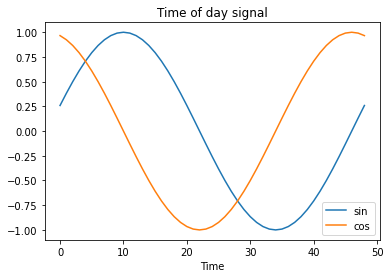

In [7]:
# Convert to secs
date_time   = pd.to_datetime(df['ds'], format = '%Y.%m.%d %H:%M:%S')
timestamp_s = date_time.map(datetime.datetime.timestamp)

day  = 24 * 60 * 60
year = 365.2425 * day

df['day.sin']  = np.sin(timestamp_s * (2 * np.pi / day))
df['day.cos']  = np.cos(timestamp_s * (2 * np.pi / day))
df['year.sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['year.cos'] = np.cos(timestamp_s * (2 * np.pi / year))

plt.plot(np.array(df['day.sin'])[49:98])
plt.plot(np.array(df['day.cos'])[49:98])
plt.xlabel('Time')
plt.legend(['sin', 'cos'], loc = 'lower right')
plt.title('Time of day signal');

The yearly time components may benefit from a single phase shift so they align with the seasonal temperature peak around the end of July and temperature trough around the end of January.  Similarly, the daily components may benefit from small daily phase shifts.

I implement two approaches to acheive this:
  1. tbats seasonal components
  2. time2vec representation

I also checked the following time component representations:
  * [savgol_filter from scipy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.savgol_filter.html)
  * [lowess from statsmodels](https://www.statsmodels.org/devel/generated/statsmodels.nonparametric.smoothers_lowess.lowess.html)
  * phase-shifted time components

These 3 methods described annual seasonality well but struggled with daily seasonality.  Check the [notebook commit history](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/main/notebooks/lstm_time_series.ipynb) if interested.



---


### tbats seasonal components - data preparation

The TBATS (exponential smoothing state space model with Box-Cox transformation, ARMA errors, trend and seasonal components) method allows the seasonality to slowly change over time.  It is a univariate method.

Time components were generated using the [tbats functions](https://rdrr.io/cran/forecast/man/tbats.html) from the [forecast](https://cran.r-project.org/web/packages/forecast/index.html) package.  Some of the forecast package authors originated the TBATS method.

Python tbats implementations:
  * [sktime tbats function](https://www.sktime.org/en/latest/api_reference/modules/auto_generated/sktime.forecasting.tbats.TBATS.html)
  * [tbats package](https://github.com/intive-DataScience/tbats)
  * neither have functions for extracting seasonal components :-(

TBATS seasonal component generation code is [here](https://github.com/makeyourownmaker/CambridgeTemperatureModel/blob/master/tbats_components.R).

,doy,secs,level,season1,season2
0,1,0,12.778523,-1.605236,-6.470564
1,1,1800,12.813697,-1.790321,-6.472173
2,1,3600,12.847716,-1.961594,-6.473835
3,1,5400,12.882007,-2.118536,-6.475488
4,1,7200,12.915066,-2.260283,-6.477141
...,...,...,...,...,...
17563,366,77400,8.812951,0.001560,-6.462863
17564,366,79200,8.837509,-0.157629,-6.464492
17565,366,81000,8.864565,-0.312037,-6.466079
17566,366,82800,8.877571,-0.460626,-6.467683


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 223250 entries, 2008-08-01 00:30:00 to 2021-04-26 01:00:00
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   ds                 223250 non-null  datetime64[ns]
 1   y                  223250 non-null  float64       
 2   humidity           223250 non-null  float64       
 3   dew.point          223250 non-null  float64       
 4   pressure           223250 non-null  float64       
 5   wind.speed.mean    223250 non-null  float64       
 6   wind.bearing.mean  223250 non-null  float64       
 7   wind.x             223250 non-null  float64       
 8   wind.y             223250 non-null  float64       
 9   day.sin            223250 non-null  float64       
 10  day.cos            223250 non-null  float64       
 11  year.sin           223250 non-null  float64       
 12  year.cos           223250 non-null  float64       
 13  level     

None

,y,humidity,dew.point,pressure,wind.speed.mean,wind.bearing.mean,wind.x,wind.y,day.sin,day.cos,year.sin,year.cos,level,season1,season2
count,223250.000000,223250.000000,223250.000000,223250.000000,223250.000000,223250.000000,2.232500e+05,223250.000000,2.232500e+05,2.232500e+05,223250.000000,223250.000000,223250.000000,223250.000000,223250.000000
mean,10.000512,78.689959,58.880634,1014.336135,4.432390,195.051399,-1.744626e+00,-1.260534,1.743988e-06,8.767618e-06,-0.005764,0.017616,10.060805,-0.000388,-0.071280
std,6.496255,17.274417,51.630120,11.935364,4.013553,82.881764,4.094410e+00,3.789181,7.071055e-01,7.071113e-01,0.710623,0.703332,1.380082,2.358819,5.344882
min,-7.000000,20.000000,-100.000000,963.000000,0.000000,0.000000,-2.880000e+01,-29.200000,-1.000000e+00,-1.000000e+00,-1.000000,-1.000000,6.400375,-4.366649,-7.547366
25%,5.200000,68.000000,20.000000,1008.000000,1.200000,135.000000,-3.889087e+00,-3.323402,-7.071068e-01,-7.071068e-01,-0.718363,-0.681585,9.000143,-1.986746,-5.406989
50%,9.600000,83.000000,60.000000,1016.000000,3.500000,225.000000,-2.828427e-01,0.000000,-1.493716e-15,2.489527e-15,-0.012640,0.032124,10.065631,-0.242041,-0.172772
75%,14.500000,92.000000,97.000000,1022.000000,6.600000,270.000000,1.592041e-16,0.070711,7.071068e-01,7.071068e-01,0.708560,0.718372,11.060212,2.207717,5.290033
max,36.100000,100.000000,209.000000,1051.000000,29.200000,360.000000,2.050610e+01,21.800000,1.000000e+00,1.000000e+00,1.000000,1.000000,14.083699,4.071156,7.555252


,ds,y,humidity,dew.point,pressure,wind.speed.mean,wind.bearing.mean,wind.x,wind.y,day.sin,day.cos,year.sin,year.cos,level,season1,season2
ds,,,,,,,,,,,,,,,,
2008-08-01 00:30:00,2008-08-01 00:30:00,19.5,65.75000,119.150000,1014.416667,1.150000,225.0,-0.813173,-0.813173,1.305262e-01,0.991445,-0.496237,-0.868187,11.665951,-2.695219,7.541814
2008-08-01 01:00:00,2008-08-01 01:00:00,19.1,49.75000,79.200000,1014.384615,1.461538,225.0,-1.033464,-1.033464,2.588190e-01,0.965926,-0.496548,-0.868009,11.670423,-2.949225,7.542366
2008-08-01 01:30:00,2008-08-01 01:30:00,19.1,66.17875,106.600000,1014.500000,1.508333,225.0,-1.066553,-1.066553,3.826834e-01,0.923880,-0.496859,-0.867831,11.658050,-3.164749,7.542400
2008-08-01 02:00:00,2008-08-01 02:00:00,19.1,58.50000,99.250000,1014.076923,1.430769,225.0,-1.011707,-1.011707,5.000000e-01,0.866025,-0.497170,-0.867653,11.646028,-3.356957,7.542557
2008-08-01 02:30:00,2008-08-01 02:30:00,19.1,66.95000,121.883333,1014.416667,1.133333,225.0,-0.801388,-0.801388,6.087614e-01,0.793353,-0.497481,-0.867475,11.626184,-3.538922,7.542711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-25 23:00:00,2021-04-25 23:00:00,3.6,61.00000,-32.000000,1028.000000,1.400000,45.0,0.989949,0.989949,-2.588190e-01,0.965926,0.914030,-0.405647,10.905638,-1.468367,-1.060521
2021-04-25 23:30:00,2021-04-25 23:30:00,3.6,64.00000,-26.000000,1028.000000,2.600000,45.0,1.838478,1.838478,-1.305262e-01,0.991445,0.913884,-0.405975,10.811524,-1.638545,-1.057270
2021-04-26 00:00:00,2021-04-26 00:00:00,3.6,58.00000,-39.000000,1028.000000,4.300000,45.0,3.040559,3.040559,-6.445228e-12,1.000000,0.913739,-0.406302,10.661863,-1.798513,-1.053898


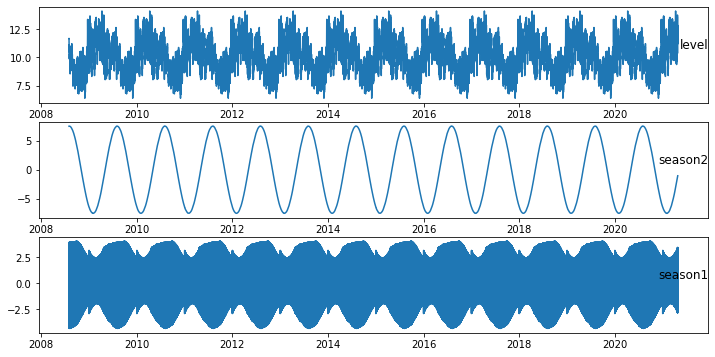

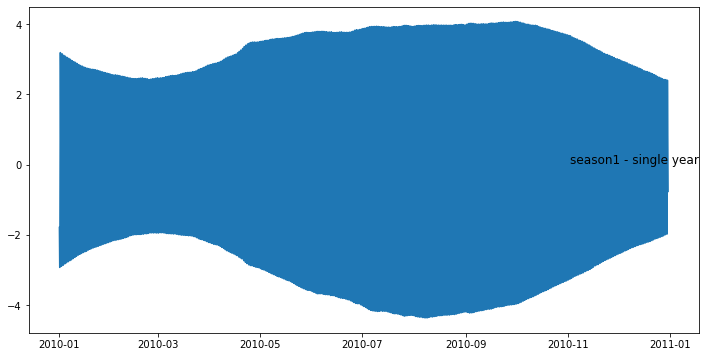

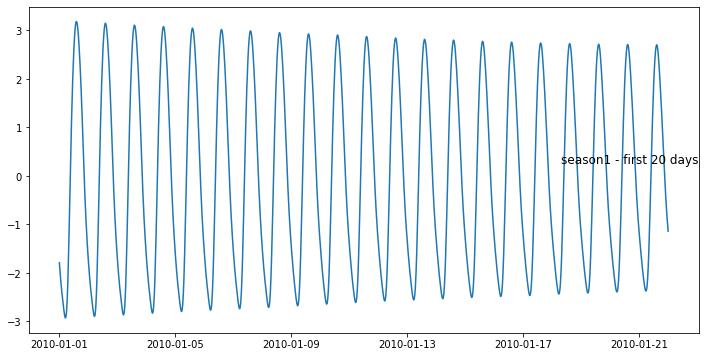

In [8]:
data_loc = "https://github.com/makeyourownmaker/CambridgeTemperatureModel/blob/master/data/tbats_components.2021.04.22.csv?raw=true"

tbats = pd.read_csv(data_loc, parse_dates = True)
tbats = tbats.drop('observed', 1)

tbats['level']   = tbats['level'] / 10
tbats['season1'] = tbats['season1'] / 10
tbats['season2'] = tbats['season2'] / 10

display(tbats)

df['doy']  = df.index.dayofyear
df['secs'] = ((df['ds'] - df['ds'].dt.normalize()) / pd.Timedelta('1 second')).astype(int)

df = pd.merge(df, tbats,  how = 'left', left_on = ['doy', 'secs'], right_on = ['doy','secs'])
df = df.drop('doy',  1)
df = df.drop('secs', 1)


df.set_index(df['ds'], drop = False, inplace = True)
#df = df[~df.index.duplicated(keep = 'first')]
df_orig = df

display(df.info())
display(df.describe())

display(df)

i = 1
cols = ['level', 'season2', 'season1']
plt.figure(figsize = (12, 6))
for col in cols:
	plt.subplot(len(cols), 1, i)
	plt.plot(df.loc[:, col])
	plt.title(col, y = 0.5, loc = 'right')
	i += 1
plt.show()

plt.figure(figsize = (12, 6))
plt.plot(df.loc[(df['ds'] > '2010-1-1') & (df['ds'] <= '2010-12-31'), 'season1'])  # arbitrarily choosing 2010
plt.title('season1 - single year', y = 0.5, loc = 'right')
plt.show()

plt.figure(figsize = (12, 6))
plt.plot(df.loc[(df['ds'] > '2010-1-1') & (df['ds'] <= '2010-1-22'), 'season1'])  # arbitrarily choosing 2010
plt.title('season1 - first 20 days', y = 0.5, loc = 'right')
plt.show()

`season2` represents annual variation and `season1` represents daily variation over a 1 year period.  `season1` is slowly changing throughout the year but is still sinusoidal.  Unfortunately, the `season1` component is net perfectly periodic.  The minimum and maximum values at the end of December is larger than the minimum and maximum values at the start of January.  Nonetheless, there is a clear reduction in component values in the winter months and increase in component values in the summer months.

See also **tbats seasonal components - model building** section below.

---

### Split data¶

I use data from 2018 for validation, 2019 for testing and the remaining data for training. These are entirely arbitrary choices. This results in an approximate 84%, 8%, 8% split for the training, validation, and test sets respectively.

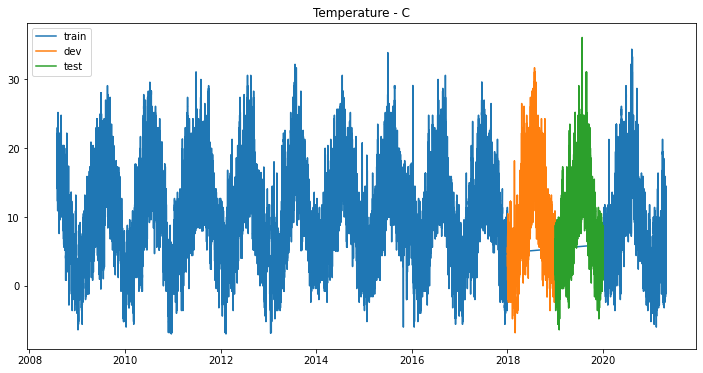

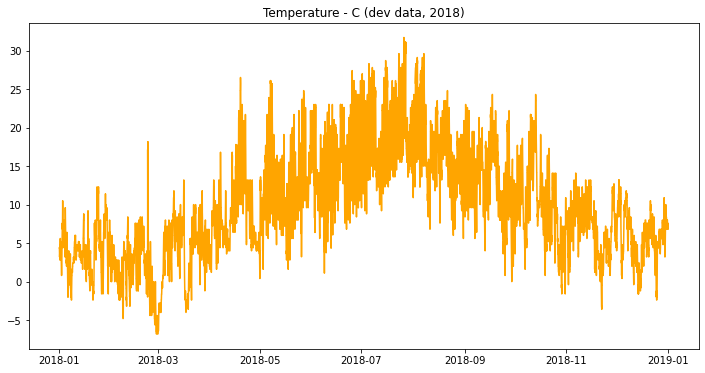

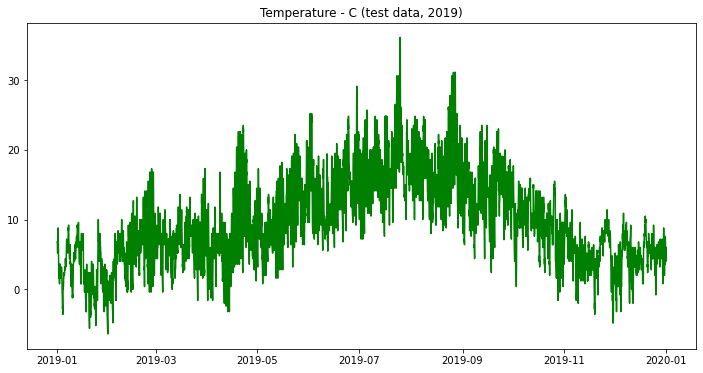

df.drop shape:  (223250, 13)
train shape:    (188210, 13)
valid shape:    (17520, 13)
test shape:     (17520, 13)


In [9]:
# keep_cols = ['y', 'humidity', 'dew.point', 'pressure', 'wind.x', 'wind.y',
#              'day.sin', 'day.cos', 'year.sin', 'year.cos', 'level', 'season1', 
#              'season2']

df['year'] = df['ds'].dt.year
train_df = df.loc[(df['year'] != 2018) & (df['year'] != 2019)]
valid_df = df.loc[df['year'] == 2018]
test_df  = df.loc[df['year'] == 2019]


plt.figure(figsize = (12, 6))
plt.plot(train_df.ds, train_df.y)
plt.plot(valid_df.ds, valid_df.y)
plt.plot(test_df.ds,  test_df.y)
plt.title('Temperature - C')
plt.legend(['train', 'dev', 'test'])
plt.show()

plt.figure(figsize = (12, 6))
plt.plot(valid_df.ds, valid_df.y, color='orange')
plt.title('Temperature - C (dev data, 2018)')
plt.show()

plt.figure(figsize = (12, 6))
plt.plot(test_df.ds, test_df.y, color='green')
plt.title('Temperature - C (test data, 2019)')
plt.show()


del_cols = ['ds', 'year', 'wind.speed.mean', 'wind.bearing.mean']
train_df = train_df.drop(del_cols, axis = 1)
valid_df = valid_df.drop(del_cols, axis = 1)
test_df  = test_df.drop(del_cols,  axis = 1)
df = df.drop(del_cols, axis = 1)

print("df.drop shape: ", df.shape)
print("train shape:   ", train_df.shape)
print("valid shape:   ", valid_df.shape)
print("test shape:    ", test_df.shape)


---

### Normalise data

Features should be scaled before neural network training. Arguably, scaling should be done using moving averages to avoid accessing future values.
Instead, simple [standard score](https://en.wikipedia.org/wiki/Standard_score) normalisation will be used.

Create [violin plot](https://en.wikipedia.org/wiki/Violin_plot) to see distribution of features.

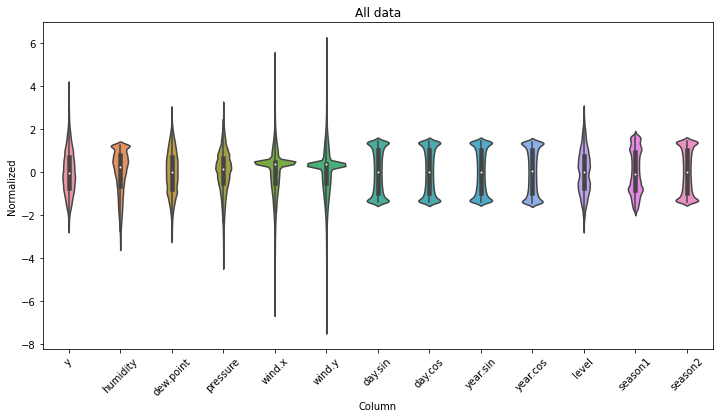

In [10]:
# df = df_orig
# df['year'] = df['ds'].dt.year
# train_df = df.loc[(df['year'] != 2018) & (df['year'] != 2019)]
# valid_df = df.loc[df['year'] == 2018]
# test_df  = df.loc[df['year'] == 2019]

# del_cols = ['ds', 'year', 'wind.speed.mean', 'wind.bearing.mean']
# train_df = train_df.drop(del_cols, axis = 1)
# valid_df = valid_df.drop(del_cols, axis = 1)
# test_df  = test_df.drop(del_cols,  axis = 1)
# df = df.drop(del_cols, axis = 1)

scaler = StandardScaler()
scaler.fit(train_df)

train_df[train_df.columns] = scaler.transform(train_df[train_df.columns] )
valid_df[valid_df.columns] = scaler.transform(valid_df[valid_df.columns] )
test_df[test_df.columns]   = scaler.transform(test_df[test_df.columns] )

df_std = scaler.transform(df)
df_std = pd.DataFrame(df_std)
df_std = df_std.melt(var_name = 'Column', value_name = 'Normalized')

plt.figure(figsize=(12, 6))
ax = sns.violinplot(x = 'Column', y = 'Normalized', data = df_std)
ax.set_xticklabels(df_std.keys(), rotation = 45)
ax.set_title('All data');

There may still be some outliers present but there are no glaring problems.

---

### Window data

Models are trained using sliding windows of samples from the data.

Window parameters to consider for the 
[tf.keras.preprocessing.timeseries_dataset_from_array](https://keras.io/api/preprocessing/timeseries/#timeseries-data-preprocessing) 
function:
 * sequence_length:
   * Length of the output sequences (in number of timesteps), or number of **lag** observations to use
 * sequence_stride:
   * Period between successive output sequences
   * For stride s, output samples start at index data[i], data[i + s], data[i + 2 * s] etc
   * s can include an **offset** and/or 1 or more **steps ahead** to forecast
 * batch_size:
   * Number of samples in each batch
 * shuffle:
   * Shuffle output samples, or use chronological order

Initial values used:
 * sequence_length (aka lags): 24 (corresponds to 12 hours)
 * steps ahead (what to forecast): 
   *  1 - 30 mins
   *  4 - 30 mins, 60 mins, 90 mins and 120 mins
   * 48 - 30 mins, 60 mins ... 1,410 mins and 1,440 mins
 * offset (space between lags and steps ahead): 0
 * batch_size: 32
 * shuffle: True for training data

The `make_dataset` function below generates [tensorflow datasets](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) for:
 * Lags, steps-ahead, offset, batch size and shuffle
 * Optionally multiple y columns (Not extensively tested)
 
Stride is used to specify offset + steps-ahead. Offset will be 0 throughout this notebook.

**TODO** Insert figure illustrating lags, offsets and steps-ahead.

`shuffle = True` is used with train data. `shuffle = False` is used with validation and test data so the residuals can be checked for heteroscadicity.

Throughout this notebook I use a shorthand notation to describe lags and strides. For example:
 * 24l_1s_2m is 24 lags, 1 step ahead, 2 times mixup
 * 24l_4s_2m is 24 lags, 4 steps ahead, 2 times mixup

#### Mixup data augmentation

Data augmentation with 
[mixup: Beyond Empirical Risk Minimization](https://arxiv.org/abs/1710.09412)
by Zhang _et al_ is used to help counter the categorical legacy from the wind bearing variable. Simple 'input mixup' is used as opposed to the batch-based mixup Zhang _et al_ focus on. Input mixup has the advantage that it can be used with non-neural network methods. With current settings these datasets are approximately 3 times larger but this can be varied. Three times more training data is manageable on Colab in terms of both training time and memory usage. Test and validation data is left unmodified.

I apply mixup between consecutive observations in the time series instead of the usual random observations. This is a fairly conservative starting point. I'd be surprised if applying mixup between consecutive days of measurements didn't give better results. Applying mixup between inputs with equal temperature values will not improve performance and will increase run time.

I don't show it in this notebook, but adding this data augmentation makes a big difference to loss values (for all model architectures considered). For example, here are results for a multi-layer perceptron (MLP) with 24 largs, 1 step ahead, 20 epochs on both less data and less thoroughly cleaned data.

|Augmentation    |	Train rmse |	Train mae |	Valid rmse |	Valid mae |
|----------------|-------------|------------|------------|------------|
|No augmentation |	0.0058     |	0.053     |	0.0054     |	0.052     |
|Input mixup     |	0.0016     |	0.025     |	0.0015     |	0.025     |

See this [commit](https://github.com/makeyourownmaker/CambridgeTemperatureModel/blob/93c754d4b1b02e1bd8f827a6f6edc145824f6d23/notebooks/keras_mlp_fcn_resnet_time_series.ipynb) 
for results from other architectures with and without 'input mixup'.

Setup functions for creating datasets:

In [11]:
def make_dataset(data, y_cols, dataset_params):  
    assert dataset_params['stride'] >= dataset_params['steps_ahead']

    total_window_size = dataset_params['lags'] + dataset_params['stride']

    data = data.drop('epoch', axis = 1, errors = 'ignore')

    if dataset_params['mix_factor'] != 0:
      data_mix = mixup(data,
                       alpha     = dataset_params['mix_alpha'],
                       factor    = dataset_params['mix_factor'],
                       time_diff = dataset_params['mix_diff'])
    else:
      data_mix = data

    data_mix = data_mix.drop('epoch', axis = 1, errors = 'ignore')
    data_np  = np.array(data_mix, dtype = np.float32)
        
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
               data    = data_np,
               targets = None,
               sequence_length = total_window_size,
               sequence_stride = 1,
               shuffle    = dataset_params['shuffle'],
               batch_size = dataset_params['bs'])
      
    col_indices = {name: i for i, name in enumerate(data.columns)}
    X_slice = slice(0, dataset_params['lags'])
    y_start = total_window_size - dataset_params['steps_ahead']
    y_slice = slice(y_start, None)


    def split_window(features):
      X = features[:, X_slice, :]
      y = features[:, y_slice, :]

      # X = tf.stack([X[:, :, col_indices[name]] for name in data.columns],
      #              axis = -1)    
      y = tf.stack([y[:, :, col_indices[name]] for name in y_cols], 
                   axis = -1)

      # Slicing doesn't preserve static shape info, so set the shapes manually.
      # This way the `tf.data.Datasets` are easier to inspect.
      X.set_shape([None, dataset_params['lags'],        None])
      y.set_shape([None, dataset_params['steps_ahead'], None])

      return X, y


    ds = ds.map(split_window)

    return ds   


def get_dataset_name(name, ds_name_params, cols):
    suffix = "_{0:d}l_{1:d}s".format(ds_name_params['lags'], 
                                     ds_name_params['steps_ahead'])

    if ds_name_params['mix_factor'] > 0:
      suffix += "_{0:d}m".format(ds_name_params['mix_factor'])

    if 'level' in  cols and 'season1' in cols and 'season2' in cols:
      suffix += '_tbats'
    elif cols.all() == 'y':
      suffix += '_t2v'  

    return name + suffix


def make_datasets(ds, train, valid, test, datasets_params, y_cols = 'y'):
    orig_mix = datasets_params['mix_factor']
    ds_train   = make_dataset(train, y_cols, datasets_params)
    train_name = get_dataset_name('train', datasets_params, train.columns)

    datasets_params['shuffle']    = False
    datasets_params['mix_factor'] = 0
    ds_valid   = make_dataset(valid, y_cols, datasets_params)
    datasets_params['mix_factor'] = orig_mix
    valid_name = get_dataset_name('valid', datasets_params, valid.columns)

    datasets_params['mix_factor'] = 0
    ds_test   = make_dataset(test, y_cols, datasets_params)
    datasets_params['mix_factor'] = orig_mix
    test_name = get_dataset_name('test', datasets_params, test.columns)

    ds[train_name] = ds_train
    ds[valid_name] = ds_valid
    ds[test_name]  = ds_test
    
    return ds


def dataset_sanity_checks(data, name):    
    print(name, "batches: ", data.cardinality().numpy())
    for batch in data.take(1):
        print("\tX (batch_size, time, features): ", batch[0].shape)
        print("\ty (batch_size, time, features): ", batch[1].shape)
        print("\tX[0][0]: ", batch[0][0])
        print("\ty[0][0]: ", batch[1][0])


def plot_dataset_examples(dataset):
    fig, axs = plt.subplots(3, 3, figsize = (15, 10))
    axs = axs.ravel()
    cols = 0

    for batch in dataset.take(1):
        for i in range(9):
          x = batch[0][i].numpy()
          cols = x.shape[1]
          axs[i].plot(x)

    fig.legend(range(1, cols+1), loc = 'upper center',  ncol = cols+1);



Create the first datasets (using day/year sin/cos time components):
  * With and without mixup
    * Single step-ahead
    * 4 steps ahead
    * 48 steps ahead

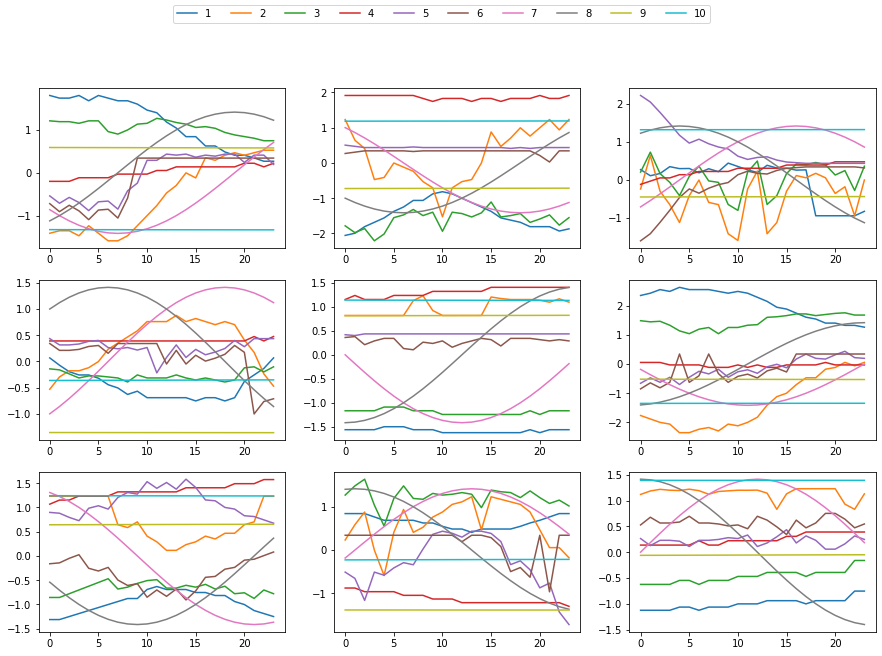

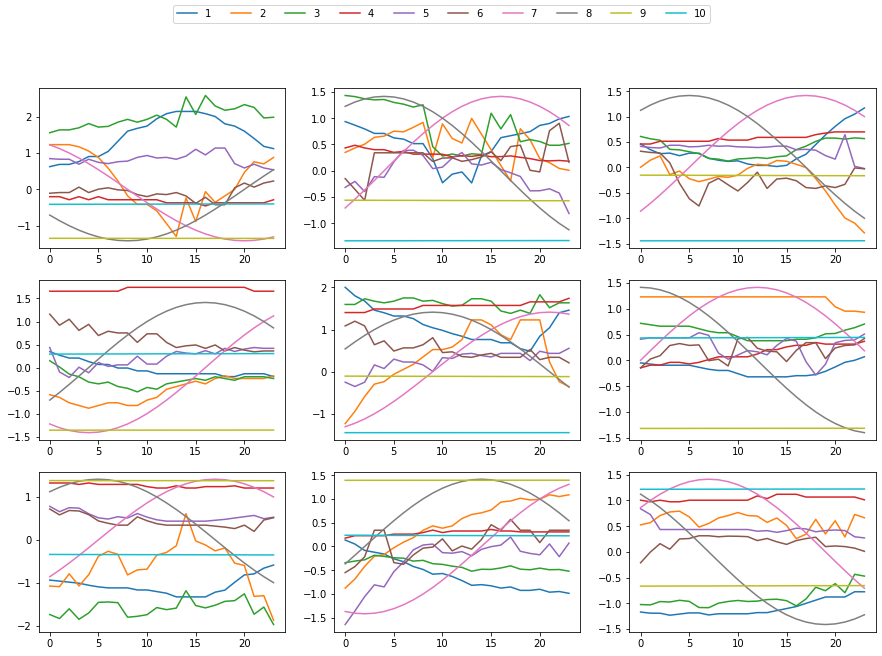

In [54]:
# Single step-ahead

def_cols = ['y', 'humidity', 'dew.point', 'pressure', 'wind.x', 'wind.y', \
            'day.sin', 'day.cos', 'year.sin', 'year.cos']  # def for default
ds = {}

params_24l_1s = {'lags':        24, 
                 'steps_ahead':  1,
                 'stride':       1, 
                 'bs':          32,
                 'shuffle':   True,
                 'mix_alpha':    4,
                 'mix_factor':   0,
                 'mix_diff':    48}
ds = make_datasets(ds, 
                   train_df.loc[:, def_cols],
                   valid_df.loc[:, def_cols],
                   test_df.loc[:,  def_cols], 
                   params_24l_1s)

params_24l_1s_2m = {'lags':        24, 
                    'steps_ahead':  1,
                    'stride':       1, 
                    'bs':          32,
                    'shuffle':   True,
                    'mix_alpha':    4,
                    'mix_factor':   2,
                    'mix_diff':    48}
ds = make_datasets(ds,
                   train_df.loc[:, def_cols],
                   valid_df.loc[:, def_cols],
                   test_df.loc[:,  def_cols], 
                   params_24l_1s_2m)


################################################################################
# 4 steps-ahead

params_24l_4s = {'lags':        24, 
                 'steps_ahead':  4,
                 'stride':       4, 
                 'bs':          32,
                 'shuffle':   True,
                 'mix_alpha':    4,
                 'mix_factor':   0,
                 'mix_diff':    48}
ds = make_datasets(ds,
                   train_df.loc[:, def_cols],
                   valid_df.loc[:, def_cols],
                   test_df.loc[:,  def_cols], 
                   params_24l_4s)

params_24l_4s_2m = {'lags':        24, 
                    'steps_ahead':  4,
                    'stride':       4, 
                    'bs':          32,
                    'shuffle':   True,
                    'mix_alpha':    4,
                    'mix_factor':   2,
                    'mix_diff':    48}
ds = make_datasets(ds,
                   train_df.loc[:, def_cols],
                   valid_df.loc[:, def_cols],
                   test_df.loc[:,  def_cols], 
                   params_24l_4s_2m)

# display(train_df.head(params['lags'] + params['steps_ahead']))
# dataset_sanity_checks(ds['train_24l_4s'], '24l 4s train');




################################################################################
# 12, 24 and 96 steps-ahead - for final testing & baseline comparison

params_24l_12s_2m = {'lags':        24, 
                     'steps_ahead': 12,
                     'stride':      12, 
                     'bs':          32,
                     'shuffle':   True,
                     'mix_alpha':    4,
                     'mix_factor':   2,
                     'mix_diff':    48}
ds = make_datasets(ds,
                   train_df.loc[:, def_cols],
                   valid_df.loc[:, def_cols],
                   test_df.loc[:,  def_cols], 
                   params_24l_12s_2m)

params_24l_24s_2m = {'lags':        24, 
                     'steps_ahead': 24,
                     'stride':      24, 
                     'bs':          32,
                     'shuffle':   True,
                     'mix_alpha':    4,
                     'mix_factor':   2,
                     'mix_diff':    48}
ds = make_datasets(ds,
                   train_df.loc[:, def_cols],
                   valid_df.loc[:, def_cols],
                   test_df.loc[:,  def_cols], 
                   params_24l_24s_2m)

params_24l_96s_2m = {'lags':        24, 
                     'steps_ahead': 96,
                     'stride':      96, 
                     'bs':          32,
                     'shuffle':   True,
                     'mix_alpha':    4,
                     'mix_factor':   2,
                     'mix_diff':    48}
ds = make_datasets(ds,
                   train_df.loc[:, def_cols],
                   valid_df.loc[:, def_cols],
                   test_df.loc[:,  def_cols], 
                   params_24l_96s_2m)


################################################################################
# 48 steps-ahead

params_24l_48s = {'lags':        24, 
                  'steps_ahead': 48,
                  'stride':      48, 
                  'bs':          32,
                  'shuffle':   True,
                  'mix_alpha':    4,
                  'mix_factor':   0,
                  'mix_diff':    48}
ds = make_datasets(ds,
                   train_df.loc[:, def_cols],
                   valid_df.loc[:, def_cols],
                   test_df.loc[:,  def_cols], 
                   params_24l_48s)

params_24l_48s_2m = {'lags':        24, 
                     'steps_ahead': 48,
                     'stride':      48, 
                     'bs':          32,
                     'shuffle':   True,
                     'mix_alpha':    4,
                     'mix_factor':   2,
                     'mix_diff':    48}
ds = make_datasets(ds,
                   train_df.loc[:, def_cols],
                   valid_df.loc[:, def_cols],
                   test_df.loc[:,  def_cols], 
                   params_24l_48s_2m)

# display(train_df.head(params['lags'] + params['steps_ahead']))
# dataset_sanity_checks(ds['train_24l_4s'], '24l 4s train');


plot_dataset_examples(ds['train_24l_1s'])
plot_dataset_examples(ds['train_24l_1s_2m'])

Plots seem to be acceptable.

---

## LSTM Model Building

Long Short Term Memory networks, or LSTMs, were originally proposed in [LONG SHORT TERM MEMORY](https://www.bioinf.jku.at/publications/older/2604.pdf). They are [recurrent neural networks](https://en.wikipedia.org/wiki/Recurrent_neural_network) which have feedback connections.

LSTMs can take entire sequences of data as input and keep track of arbitrary long-term dependencies. A LSTM unit is composed of a cell and three gates. The cell remembers values over arbitrary time intervals and the input, output and forget gates regulate the flow of information into and out of the cell.

**TODO** Include basic LSTM diagram

The following are a few points I consider when building these LSTM models.

Forecast horizons:
  * next 30 mins - 1 step ahead
  * next 2 hours - 4 steps ahead
  * next 24 hours - 48 steps ahead
  * horizon is abbreviated to `h` in the interrim results tables **TODO** Check me

Metrics:
 * rmse - root mean squared error
 * mae - median absolute error
 * mape - mean absolute percentage error 
   * mape fails when values, like temperature, become zero

LSTM enhancements:
 * input mixup
 * time2vec representation
   * initially on univariate data
 * tbats components
   * on multivariate data
 * wind - drop or not?
 * batch mixup?
 * test time augmentation

Parameters to consider optimising:
 * Learning rate - use LRFinder :-)
 * Optimiser - stick with Adam
 * Shuffle - true for training
 * Number of feature maps
   * 8, 16, 32
 * mixup
   * factor - 1, 2, 3, 4, 5
   * alpha - 1, 2, 3, 4
   * time diff - 1, ..., 48
     * period between 2 data subsets to run mixup on
     * **TODO** should this be 1 or number of lagged variables?
     * **TODO** for time_diff > 1 lambda should probably be the same value for each 
       time_diff period
       * i.e. for time_diff = 2, l = l1, l1, l2, l2, l3, l3, ...
 * dropout
   * dropout
   * recurrent_dropout
 * epochs


LSTM architectures to consider:
 * Stacked LSTM
   * Only two layers deep
 * Encoder-decoder
   * good for sequence-to-sequence prediction problems
 * Gated Residual Networks and Variable Selection Networks
   * GRNs apply non-linear processing only where needed
   * VSNs remove noisy inputs


---


### Learning rate finder
Leslie Smith was one of the first people to work on finding optimal learning rates for deep learning networks in [Cyclical Learning Rates for Training Neural Networks](https://arxiv.org/abs/1506.01186). Jeremy Howard from [fast.ai](https://www.fast.ai/) popularised the learning rate finder used here.

Before building any models, I use a modified version of [Pavel Surmenok's Keras learning rate finder](https://github.com/surmenok/keras_lr_finder) to get reasonably close to the optimal learning rate. It's a single small class which I add support for tensorflow datasets to, customise the graphics and add a simple summary function to.

Setup learning rate finder class for later usage:

In [13]:
from keras.callbacks import LambdaCallback
import keras.backend as K
import math


class LRFinder:
    """
    Plots the change of the loss function of a Keras model when the learning rate is exponentially increasing.
    See for details:
    https://towardsdatascience.com/estimating-optimal-learning-rate-for-a-deep-neural-network-ce32f2556ce0
    """

    def __init__(self, model):
        self.model  = model
        self.losses = []
        self.lrs    = []
        self.best_lr   = 0.001
        self.best_loss = 1e9


    def on_batch_end(self, batch, logs):
        # Log the learning rate
        lr = K.get_value(self.model.optimizer.lr)
        self.lrs.append(lr)

        # Log the loss
        loss = logs['loss']
        self.losses.append(loss)

        # Check whether the loss got too large or NaN
        if batch > 5 and (math.isnan(loss) or loss > self.best_loss * 4):
            self.model.stop_training = True
            return

        if loss < self.best_loss:
            self.best_loss = loss

        # Increase the learning rate for the next batch
        lr *= self.lr_mult
        K.set_value(self.model.optimizer.lr, lr)


    def find_ds(self, train_ds, start_lr, end_lr, batch_size=64, epochs=1, **kw_fit):
        # If x_train contains data for multiple inputs, use length of the first input.
        # Assumption: the first element in the list is single input; NOT a list of inputs.
        # N = x_train[0].shape[0] if isinstance(x_train, list) else x_train.shape[0]
        N = train_ds.cardinality().numpy()

        # Compute number of batches and LR multiplier
        num_batches = epochs * N / batch_size
        self.lr_mult = (float(end_lr) / float(start_lr)) ** (float(1) / float(num_batches))
        #print(self.lr_mult)
        # Save weights into a file
        initial_weights = self.model.get_weights()

        # Remember the original learning rate
        original_lr = K.get_value(self.model.optimizer.lr)

        # Set the initial learning rate
        K.set_value(self.model.optimizer.lr, start_lr)

        callback = LambdaCallback(on_batch_end=lambda batch, logs: self.on_batch_end(batch, logs))

        self.model.fit(train_ds,
                       batch_size=batch_size, epochs=epochs,
                       callbacks=[callback],
                       **kw_fit)

        # Restore the weights to the state before model fitting
        self.model.set_weights(initial_weights)

        # Restore the original learning rate
        K.set_value(self.model.optimizer.lr, original_lr)


    def plot_loss(self, axs, sma, n_skip_beginning, n_skip_end, x_scale='log'):
        """
        Plots the loss.
        Parameters:
            n_skip_beginning - number of batches to skip on the left.
            n_skip_end - number of batches to skip on the right.
        """
        lrs = self.lrs[n_skip_beginning:-n_skip_end]
        losses = self.losses[n_skip_beginning:-n_skip_end]
        best_lr = self.get_best_lr(sma, n_skip_beginning, n_skip_end)

        axs[0].set_ylabel("loss")
        axs[0].set_xlabel("learning rate (log scale)")
        axs[0].plot(lrs, losses)
        axs[0].vlines(best_lr, np.min(losses), np.max(losses), linestyles='dashed')
        axs[0].set_xscale(x_scale)


    def plot_loss_change(self, axs, sma, n_skip_beginning, n_skip_end, y_lim=None):
        """
        Plots rate of change of the loss function.
        Parameters:
            axs - subplot axes
            sma - number of batches for simple moving average to smooth out the curve.
            n_skip_beginning - number of batches to skip on the left.
            n_skip_end - number of batches to skip on the right.
            y_lim - limits for the y axis.
        """
        derivatives = self.get_derivatives(sma)[n_skip_beginning:-n_skip_end]
        lrs = self.lrs[n_skip_beginning:-n_skip_end]
        best_lr = self.get_best_lr(sma, n_skip_beginning, n_skip_end)
        y_min, y_max = np.min(derivatives), np.max(derivatives)
        x_min, x_max = np.min(lrs), np.max(lrs)

        axs[1].set_ylabel("rate of loss change")
        axs[1].set_xlabel("learning rate (log scale)")
        axs[1].plot(lrs, derivatives)
        axs[1].vlines(best_lr, y_min, y_max, linestyles='dashed')
        axs[1].hlines(0, x_min, x_max, linestyles='dashed')
        axs[1].set_xscale('log')
        if y_lim == None:
            axs[1].set_ylim([y_min, y_max])
        else:
            axs[1].set_ylim(y_lim)


    def get_derivatives(self, sma):
        assert sma >= 1
        derivatives = [0] * sma
        for i in range(sma, len(self.lrs)):
            derivatives.append((self.losses[i] - self.losses[i - sma]) / sma)
            
        return derivatives


    def get_best_lr(self, sma, n_skip_beginning, n_skip_end):
        derivatives = self.get_derivatives(sma)
        best_der_idx = np.argmin(derivatives[n_skip_beginning:-n_skip_end])
        #print("sma:", sma)
        #print("n_skip_beginning:", n_skip_beginning)
        #print("n_skip_end:", n_skip_end)
        #print("best_der_idx:", best_der_idx)
        #print("len(derivatives):", len(derivatives))
        #print("derivatives:", derivatives)
        return self.lrs[n_skip_beginning:-n_skip_end][best_der_idx]


    def summarise_lr(self, train_ds, start_lr, end_lr, batch_size=32, epochs=1, sma=1, n_skip_beginning=200, **kw_fit):
        self.find_ds(train_ds, start_lr, end_lr, batch_size, epochs)
        #print("sma:", sma)
        #print("n_skip_beginning:", n_skip_beginning)
        fig, axs = plt.subplots(1, 2, figsize = (9, 6), tight_layout = True)
        axs = axs.ravel()
        self.plot_loss(axs, sma, n_skip_beginning=n_skip_beginning, n_skip_end=5)
        self.plot_loss_change(axs, sma=sma, n_skip_beginning=n_skip_beginning, n_skip_end=5)
        plt.show()

        best_lr = self.get_best_lr(sma=sma, n_skip_beginning=n_skip_beginning, n_skip_end=5)
        self.best_lr = best_lr
        print("best lr:", best_lr, "\n")


lrf = {}


---

Next, define a vanilla LSTM network in the `build_vanilla_lstm_model` function and run the learning rate finder.  Additionally, define some utility functions for plotting and summarising results.

In [14]:
def compile_fit_validate(model, train, valid, epochs = 5, verbose = 2):
    # Reduces variance in results but won't eliminate it :-(
    random.seed(42)
    np.random.seed(42)
    tf.random.set_seed(42)

    # opt = Adam(learning_rate = 0.001)
    opt = Adam(lrf[model.name].best_lr)

    model.compile(optimizer = opt, loss = 'mse', metrics = ['mae']) 
       
    es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 10)
    lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 5, min_lr = 0.0001)
   
    h = model.fit(train, validation_data = valid,
                  epochs = epochs, verbose = verbose, callbacks = [es, lr])
    
    return h

    
def plot_history(h, name, epochs = 10):
    fig, axs = plt.subplots(1, 2, figsize = (9, 6), tight_layout = True)
    axs = axs.ravel()

    axs[0].plot(h.history['loss'])
    axs[0].plot(h.history['val_loss'])
    axs[0].set_title(name + ' loss')
    axs[0].set_xticklabels(range(1, epochs + 1))
    axs[0].set_xticks(range(0, epochs))
    axs[0].set_ylabel('loss')
    axs[0].set_xlabel('epoch')
    axs[0].legend(['train', 'valid'], loc = 'upper right')

    axs[1].plot(h.history['mae'])
    axs[1].plot(h.history['val_mae'])
    axs[1].set_title(name + ' mae')
    axs[1].set_xticks(range(0, epochs))
    axs[1].set_xticklabels(range(1, epochs + 1))
    axs[1].set_title(name + ' mae')
    axs[1].set_ylabel('mae')
    axs[1].set_xlabel('epoch')
    axs[1].legend(['train', 'valid'], loc = 'upper right')
    plt.show()

    return None

    
def print_min_loss(h, name):
    argmin_loss     = np.argmin(np.array(h.history['loss']))
    argmin_val_loss = np.argmin(np.array(h.history['val_loss']))
    min_loss        = h.history['loss'][argmin_loss]
    min_val_loss    = h.history['val_loss'][argmin_val_loss]
    mae             = h.history['mae'][argmin_loss]
    val_mae         = h.history['val_mae'][argmin_val_loss]
    
    txt = "{0:s} {1:s} min loss: {2:f}\tmae: {3:f}\tepoch: {4:d}"
    print(txt.format(name, "train", min_loss,     mae,     argmin_loss + 1))
    print(txt.format(name, "valid", min_val_loss, val_mae, argmin_val_loss + 1))
    print()

    return None


def get_io_shapes(data):
    for batch in data.take(1):
        in_shape  = batch[0][0].shape
        out_shape = batch[1][0].shape
        
    return in_shape, out_shape


def build_vanilla_lstm_model(name, data, n_feature_maps = 8):
    in_shape, out_shape = get_io_shapes(data)
    out_steps = out_shape[0]

    lstm = Sequential(name = name)
    lstm.add(InputLayer(input_shape = in_shape))

    # Shape [batch, time, features] => [batch, n_feature_maps]
    lstm.add(LSTM(n_feature_maps, return_sequences = False))

    # Shape => [batch, out_steps]
    lstm.add(Dense(out_steps,
                   kernel_initializer = tf.initializers.zeros()))

    return lstm


def run_model(model, train, valid, epochs = 5):
    in_shape, out_shape = get_io_shapes(train)
    model_id = model.name + ' model - ' + str(in_shape[0]) + \
               ' lags ' + str(out_shape[0]) + ' steps-ahead -'
    
    model.summary()
    h = compile_fit_validate(model, train, valid, epochs)
    plot_history(h, model_id, epochs)
    print_min_loss(h, model_id)
    
    return h


def run_lrf(models, train_data, name, lrf, sum_lr_params):
    model = models[name]
    model.compile(loss = 'mse', metrics = ['mae'])
    lrf_inner = LRFinder(model)
    lrf_inner.summarise_lr(train_data, *sum_lr_params)
    lrf[name] = lrf_inner

    return lrf


Create the first models and run learning rate finder to get optimal learning rates:
  * 1, 4 and 48 steps ahead
  * with and without mixup

Epoch 1/5
5881/5881 [==============================] - 14s 1ms/step - loss: 0.6244 - mae: 0.4196


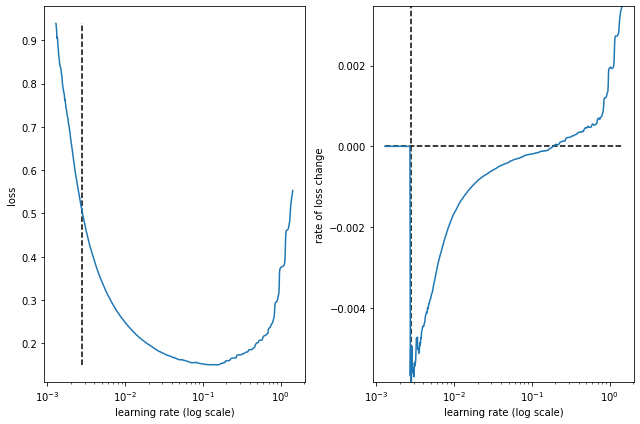

best lr: 0.0028077543 

Epoch 1/5
5881/5881 [==============================] - 10s 1ms/step - loss: 0.6543 - mae: 0.4627


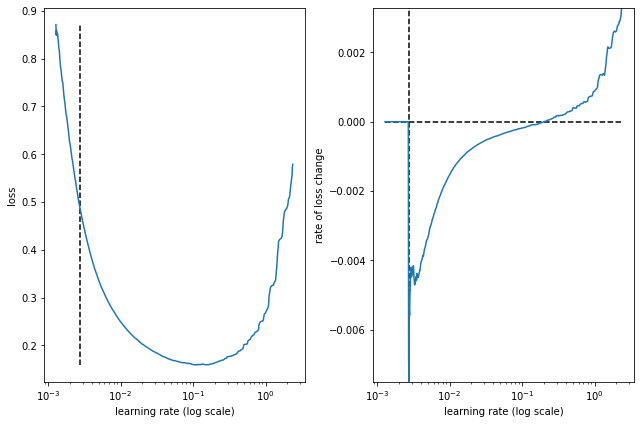

best lr: 0.0027520296 

Epoch 1/5
5880/5880 [==============================] - 10s 1ms/step - loss: 1.0792 - mae: 0.6135


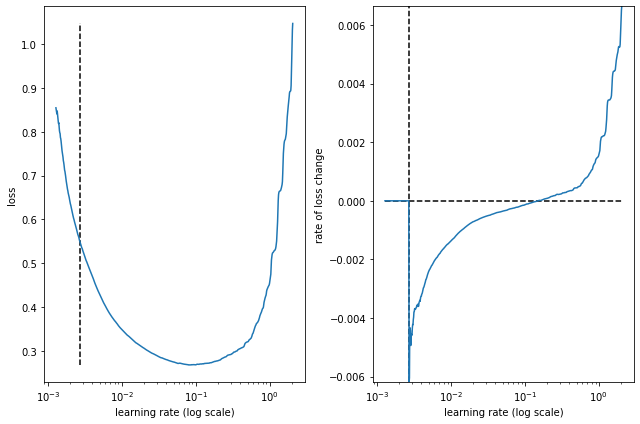

best lr: 0.002725049 

Epoch 1/5
17641/17641 [==============================] - 25s 1ms/step - loss: 0.2399 - mae: 0.2781


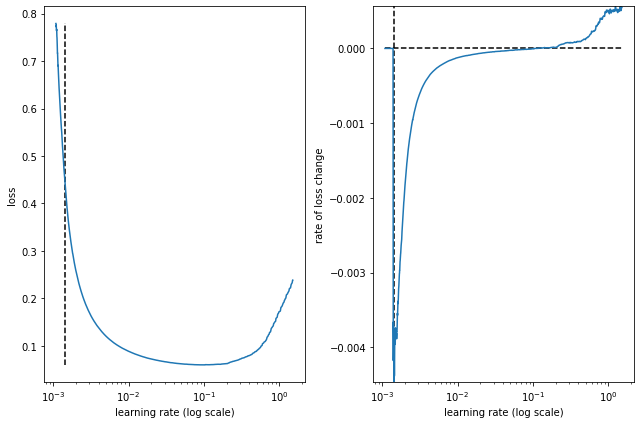

best lr: 0.0014250287 

Epoch 1/5
17641/17641 [==============================] - 24s 1ms/step - loss: 0.2969 - mae: 0.3083


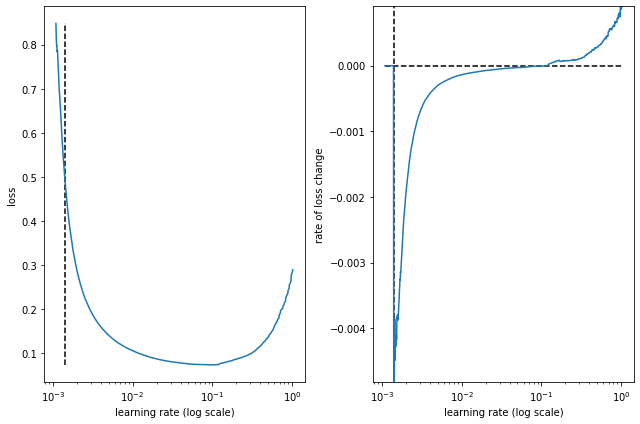

best lr: 0.0014155371 

Epoch 1/5
17640/17640 [==============================] - 28s 1ms/step - loss: 0.6469 - mae: 0.5140


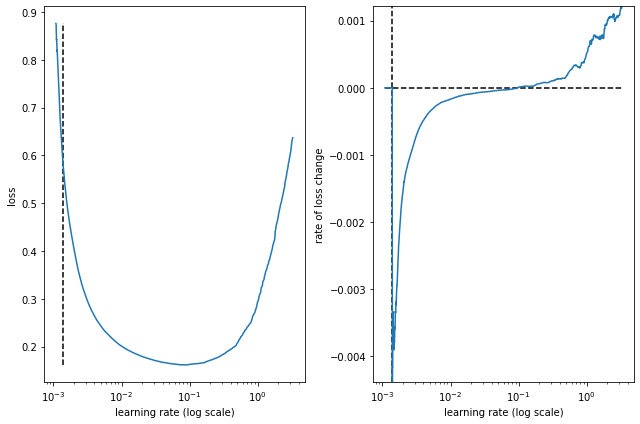

best lr: 0.0013967697 



In [15]:
models = {}
feat_maps = 16

models['lstm_24l_1s'] = build_vanilla_lstm_model('lstm_24l_1s', 
                                                 ds['train_24l_1s'], 
                                                 feat_maps)
models['lstm_24l_4s'] = build_vanilla_lstm_model('lstm_24l_4s', 
                                                 ds['train_24l_4s'], 
                                                 feat_maps)
models['lstm_24l_48s'] = build_vanilla_lstm_model('lstm_24l_48s', 
                                                  ds['train_24l_48s'], 
                                                  feat_maps)

models['lstm_24l_1s_2m'] = build_vanilla_lstm_model('lstm_24l_1s_2m', 
                                                    ds['train_24l_1s_2m'], 
                                                    feat_maps)
models['lstm_24l_4s_2m'] = build_vanilla_lstm_model('lstm_24l_4s_2m', 
                                                    ds['train_24l_4s_2m'], 
                                                    feat_maps)
models['lstm_24l_48s_2m'] = build_vanilla_lstm_model('lstm_24l_48s_2m', 
                                                     ds['train_24l_48s_2m'], 
                                                     feat_maps)


sum_params = [0.001, 10, 32, 5, 100, 25]
lrf = run_lrf(models, ds['train_24l_1s'],  'lstm_24l_1s',  lrf, sum_params)
lrf = run_lrf(models, ds['train_24l_4s'],  'lstm_24l_4s',  lrf, sum_params)
lrf = run_lrf(models, ds['train_24l_48s'], 'lstm_24l_48s', lrf, sum_params)

lrf = run_lrf(models, ds['train_24l_1s_2m'],  'lstm_24l_1s_2m',  lrf, sum_params)
lrf = run_lrf(models, ds['train_24l_4s_2m'],  'lstm_24l_4s_2m',  lrf, sum_params)
lrf = run_lrf(models, ds['train_24l_48s_2m'], 'lstm_24l_48s_2m', lrf, sum_params)

Unsurprisingly, the optimal learning rates are similar for 3 without mixup models.  Similarly, the optimal learning rates are similar for 3 with mixup models but different to the without mixup optimal learning rates.

The learning rate finder has a surprisingly low run time; possibly because the loss quickly becomes infinite at high learning rates.

Unaugmented single step ahead (both univariate temperature and multivariate) and 4 steps ahead data sets have similar optimal learning rates.  Best learning rates for the single step ahead and 4 steps ahead data sets with mixup are very similar.  The learning rate finder is ran for two Time2Vec models below.


---

Finally, run vanilla LSTM with optimised learning rates:
 * single step-ahead
   * without mixup
   * with mixup
 * approx. run time (google colab with gpu)
   * 3 mins without mixup
   * 9 mins with mixup

Model: "lstm_24l_1s"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 16)                1728      
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 1,745
Trainable params: 1,745
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
5881/5881 - 41s - loss: 0.0164 - mae: 0.0715 - val_loss: 0.0111 - val_mae: 0.0616
Epoch 2/10
5881/5881 - 38s - loss: 0.0099 - mae: 0.0617 - val_loss: 0.0103 - val_mae: 0.0582
Epoch 3/10
5881/5881 - 38s - loss: 0.0097 - mae: 0.0610 - val_loss: 0.0113 - val_mae: 0.0642
Epoch 4/10
5881/5881 - 38s - loss: 0.0095 - mae: 0.0606 - val_loss: 0.0102 - val_mae: 0.0582
Epoch 5/10
5881/5881 - 38s - loss: 0.0094 - mae: 0.0602 - val_loss: 0.0099 - val_mae: 0.0567
Epoch 6/10
5881/5881 - 38s - loss: 0.0093 - mae: 0

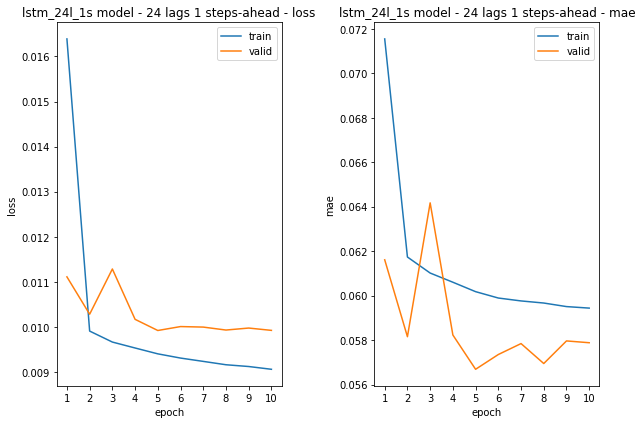

lstm_24l_1s model - 24 lags 1 steps-ahead - train min loss: 0.009061	mae: 0.059438	epoch: 10
lstm_24l_1s model - 24 lags 1 steps-ahead - valid min loss: 0.009921	mae: 0.056687	epoch: 5

Model: "lstm_24l_1s_2m"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 16)                1728      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 1,745
Trainable params: 1,745
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
17641/17641 - 111s - loss: 0.0106 - mae: 0.0579 - val_loss: 0.0100 - val_mae: 0.0571
Epoch 2/10
17641/17641 - 109s - loss: 0.0071 - mae: 0.0518 - val_loss: 0.0099 - val_mae: 0.0573
Epoch 3/10
17641/17641 - 109s - loss: 0.0069 - mae: 0.0513 - val_loss: 0.0099 - val_mae: 0.0577
Epoch 4/10
17641/17641 - 108s - loss: 

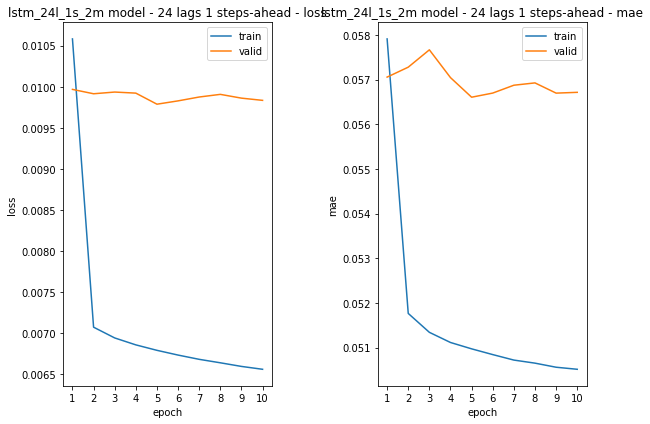

lstm_24l_1s_2m model - 24 lags 1 steps-ahead - train min loss: 0.006563	mae: 0.050517	epoch: 10
lstm_24l_1s_2m model - 24 lags 1 steps-ahead - valid min loss: 0.009788	mae: 0.056605	epoch: 5



In [ ]:
h = {}  # history
h['lstm_24l_1s'] = run_model(models['lstm_24l_1s'], ds['train_24l_1s'], ds['valid_24l_1s'], epochs = 10)

# mix = 2, alpha = 4, time_diff = 48
h['lstm_24l_1s_2m'] = run_model(models['lstm_24l_1s_2m'], ds['train_24l_1s_2m'], ds['valid_24l_1s_2m'], epochs = 10)

...

---

Secondly, vanilla LSTM with optimised learning rates:
 * 4 steps ahead
   * without mixup
   * with mixup

Model: "lstm_24l_4s"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 16)                1728      
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 68        
Total params: 1,796
Trainable params: 1,796
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
5881/5881 - 41s - loss: 0.0285 - mae: 0.1058 - val_loss: 0.0226 - val_mae: 0.0926
Epoch 2/10
5881/5881 - 38s - loss: 0.0203 - mae: 0.0933 - val_loss: 0.0214 - val_mae: 0.0903
Epoch 3/10
5881/5881 - 38s - loss: 0.0197 - mae: 0.0918 - val_loss: 0.0211 - val_mae: 0.0900
Epoch 4/10
5881/5881 - 40s - loss: 0.0194 - mae: 0.0911 - val_loss: 0.0213 - val_mae: 0.0901
Epoch 5/10
5881/5881 - 39s - loss: 0.0191 - mae: 0.0906 - val_loss: 0.0209 - val_mae: 0.0890
Epoch 6/10
5881/5881 - 39s - loss: 0.0189 - mae: 0

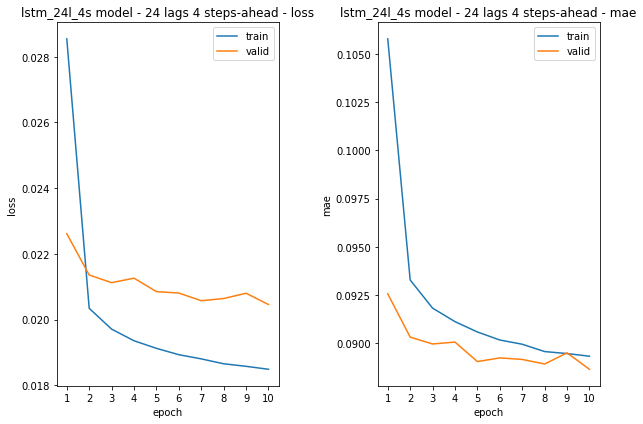

lstm_24l_4s model - 24 lags 4 steps-ahead - train min loss: 0.018488	mae: 0.089319	epoch: 10
lstm_24l_4s model - 24 lags 4 steps-ahead - valid min loss: 0.020459	mae: 0.088642	epoch: 10

Model: "lstm_24l_4s_2m"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 16)                1728      
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 68        
Total params: 1,796
Trainable params: 1,796
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
17641/17641 - 113s - loss: 0.0187 - mae: 0.0849 - val_loss: 0.0220 - val_mae: 0.0902
Epoch 2/10
17641/17641 - 111s - loss: 0.0137 - mae: 0.0761 - val_loss: 0.0209 - val_mae: 0.0885
Epoch 3/10
17641/17641 - 111s - loss: 0.0134 - mae: 0.0752 - val_loss: 0.0205 - val_mae: 0.0875
Epoch 4/10
17641/17641 - 110s - loss:

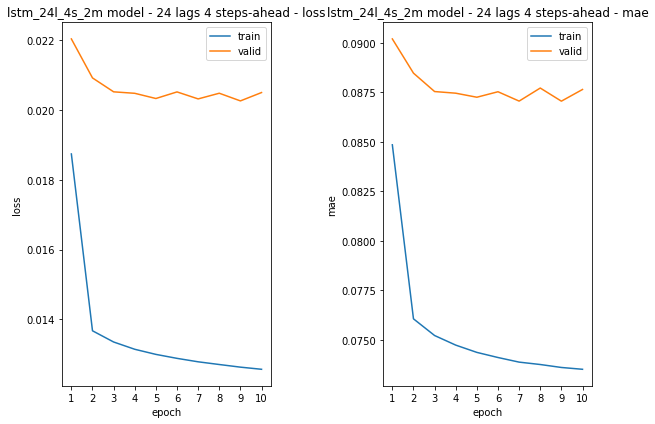

lstm_24l_4s_2m model - 24 lags 4 steps-ahead - train min loss: 0.012568	mae: 0.073522	epoch: 10
lstm_24l_4s_2m model - 24 lags 4 steps-ahead - valid min loss: 0.020265	mae: 0.087053	epoch: 9



In [ ]:
h['lstm_24l_4s'] = run_model(models['lstm_24l_4s'], ds['train_24l_4s'], ds['valid_24l_4s'], epochs = 10)

h['lstm_24l_4s_2m'] = run_model(models['lstm_24l_4s_2m'], ds['train_24l_4s_2m'], ds['valid_24l_4s_2m'], epochs = 10)

...


---

Thirdly, vanilla LSTM with optimised learning rates:
 * 48 steps ahead
   * without mixup
   * with mixup

Model: "lstm_24l_48s"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 16)                1728      
_________________________________________________________________
dense_2 (Dense)              (None, 48)                816       
Total params: 2,544
Trainable params: 2,544
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
5880/5880 - 41s - loss: 0.1259 - mae: 0.2660 - val_loss: 0.1289 - val_mae: 0.2660
Epoch 2/10
5880/5880 - 39s - loss: 0.1099 - mae: 0.2487 - val_loss: 0.1263 - val_mae: 0.2630
Epoch 3/10
5880/5880 - 39s - loss: 0.1077 - mae: 0.2462 - val_loss: 0.1252 - val_mae: 0.2618
Epoch 4/10
5880/5880 - 39s - loss: 0.1065 - mae: 0.2448 - val_loss: 0.1254 - val_mae: 0.2626
Epoch 5/10
5880/5880 - 39s - loss: 0.1057 - mae: 0.2440 - val_loss: 0.1249 - val_mae: 0.2616
Epoch 6/10
5880/5880 - 39s - loss: 0.1051 - mae: 

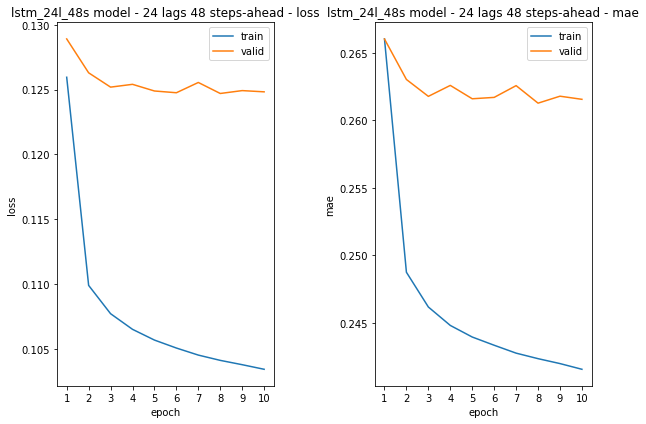

lstm_24l_48s model - 24 lags 48 steps-ahead - train min loss: 0.103432	mae: 0.241569	epoch: 10
lstm_24l_48s model - 24 lags 48 steps-ahead - valid min loss: 0.124698	mae: 0.261266	epoch: 8

Model: "lstm_24l_48s_2m"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 16)                1728      
_________________________________________________________________
dense_5 (Dense)              (None, 48)                816       
Total params: 2,544
Trainable params: 2,544
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
17640/17640 - 113s - loss: 0.0864 - mae: 0.2175 - val_loss: 0.1263 - val_mae: 0.2604
Epoch 2/10
17640/17640 - 111s - loss: 0.0757 - mae: 0.2039 - val_loss: 0.1251 - val_mae: 0.2599
Epoch 3/10
17640/17640 - 111s - loss: 0.0740 - mae: 0.2015 - val_loss: 0.1236 - val_mae: 0.2585
Epoch 4/10
17640/17640 - 111s - l

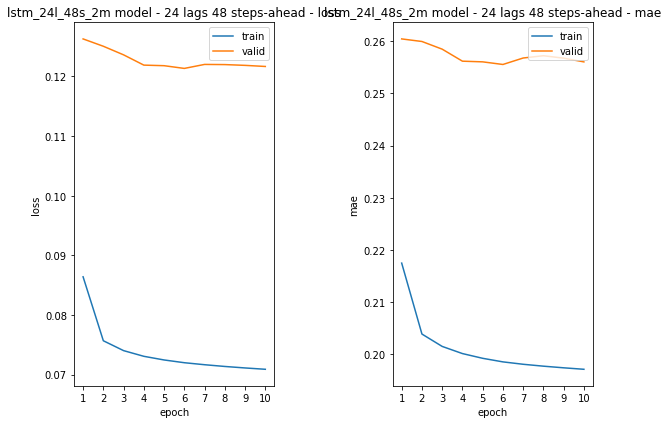

lstm_24l_48s_2m model - 24 lags 48 steps-ahead - train min loss: 0.070905	mae: 0.197162	epoch: 10
lstm_24l_48s_2m model - 24 lags 48 steps-ahead - valid min loss: 0.121351	mae: 0.255540	epoch: 6



In [ ]:
h['lstm_24l_48s'] = run_model(models['lstm_24l_48s'], ds['train_24l_48s'], ds['valid_24l_48s'], epochs = 10)

h['lstm_24l_48s_2m'] = run_model(models['lstm_24l_48s_2m'], ds['train_24l_48s_2m'], ds['valid_24l_48s_2m'], epochs = 10)

...

---

### Time2Vec


The [Time2Vec](https://arxiv.org/pdf/1907.05321.pdf) method learns a vector representation of both periodic and non-periodic patterns using `sin` and linear activations.  Time can be measured on different scales, eg. years, days, hours.  Time2Vec is invariant to time rescaling and is  model-agnostic, meaning it can be used with many existing architectures.  

The learnable parameters are the frequencies and phase shifts of the sine function.  There are similarities with the hardcoded daily and yearly `sin` time components used above; which use 2 frequencies, no phase shifts and no non-periodic components.  See the [Time2Vec paper](https://arxiv.org/pdf/1907.05321.pdf) for a detailed explanation and negative reviews on [OpenReview.net](https://openreview.net/forum?id=rklklCVYvB).

Fourier terms, which use equally spaced frequencies, are one obvious alternative temporal representation.

The Time2Vec representation is implemented using a keras layer based on code from [Marco Cerliani](https://github.com/cerlymarco/MEDIUM_NoteBook/blob/master/Time2Vec/Time2Vec.ipynb), which has been adapted for use with my utilility functions.

The `NN` and `T2V_NN` function parameters used below were chosen to produce similarly sized models for a fair comparison (4,124 for `NN` and 4,154 for `T2V_NN`).  Only univariate temperature data is considered.


In [ ]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import *

class T2V(Layer):
    
    def __init__(self, output_dim = None, **kwargs):
        '''
        Implements a Time2Vec layer based on:
          [1] Time2Vec: Learning a Vector Representation of Time,
              Kazemi et al., 2019.
        '''
        self.output_dim = output_dim
        super(T2V, self).__init__(**kwargs)
        
    def build(self, input_shape):
        # W and P correspond to omega_i and phi_i for i != 0 from [1]
        # omega_i and phi_i represent the frequency and phase-shift
        self.W = self.add_weight(name = 'W',
                                shape = (input_shape[-1], self.output_dim),
                                initializer = 'uniform',
                                trainable   = True)

        self.P = self.add_weight(name = 'P',
                                shape = (input_shape[1], self.output_dim),
                                initializer = 'uniform',
                                trainable   = True)

        # w and p correspond to omega_0 and phi_0 for i = 0 from [1]
        self.w = self.add_weight(name = 'w',
                                shape = (input_shape[1], 1),
                                initializer = 'uniform',
                                trainable   = True)

        self.p = self.add_weight(name = 'p',
                                shape = (input_shape[1], 1),
                                initializer = 'uniform',
                                trainable   = True)

        super(T2V, self).build(input_shape)
        
    def call(self, x):
        '''
        Time2Vec layer forward method.  The input signal (tensor) contains
        a sequence with dimension -> features_dim.
            Args:
                x (tensor):       Input signal (tensor)
                                  (batch_size, sequence_length, features_dim)
            Returns:
                A tensor that contains the concatenation of a predictive and a
                progressive signal, respectively.
            Notes:
                For instance, if the time2vec layer is being used in timeseries
                prediction the sequence length is the length of the timeseries
                chunk and the features dimension is 1 if the prediction horizon
                is one.

        :return: A Tensor with shape (batch_size, feature_size, length of time vector representation + 1)
        '''
        original  = self.w * x + self.p
        sin_trans = K.sin(K.dot(x, self.W) + self.P)
        
        return K.concatenate([sin_trans, original], -1)


def T2V_NN(seq_len, n_feature_maps, model_name, t2v_size = 33):
        
    inp = Input(shape = (seq_len, 1))

    x = T2V(t2v_size)(inp)
    x = LSTM(n_feature_maps)(x)
    x = Dense(1)(x)
    
    m = Model(inp, x, name = model_name)
    
    return m


def NN(seq_len, n_feature_maps, model_name):
        
    inp = Input(shape = (seq_len, 1))

    x = LSTM(n_feature_maps)(inp)
    x = Dense(1)(x)
    
    m = Model(inp, x, name = model_name)
    
    return m



Create the time2vec datasets:
  * Univariate
    * Single step-ahead
    * 4 steps ahead
    * 48 steps ahead

In [ ]:
# Time2vec single step-ahead

t2v_cols = ['y']

params_24l_1s = {'lags':        24, 
                 'steps_ahead':  1,
                 'stride':       1, 
                 'bs':          32,
                 'shuffle':   True,
                 'mix_alpha':    4,
                 'mix_factor':   0,
                 'mix_diff':    48}
ds = make_datasets(ds,
                   train_df.loc[:, t2v_cols],
                   valid_df.loc[:, t2v_cols],
                   test_df.loc[:,  t2v_cols], 
                   params_24l_1s)

params_24l_1s_2m = {'lags':        24, 
                    'steps_ahead':  1,
                    'stride':       1, 
                    'bs':          32,
                    'shuffle':   True,
                    'mix_alpha':    4,
                    'mix_factor':   2,
                    'mix_diff':    48}
#ds = make_datasets(ds,
#                   train_df.loc[:, t2v_cols],
#                   valid_df.loc[:, t2v_cols],
#                   test_df.loc[:,  t2v_cols], 
#                   params_24l_1s_2m)


################################################################################

params_24l_48s = {'lags':        24, 
                  'steps_ahead': 48,
                  'stride':      48, 
                  'bs':          32,
                  'shuffle':   True,
                  'mix_alpha':    4,
                  'mix_factor':   0,
                  'mix_diff':    48}
ds = make_datasets(ds,
                   train_df.loc[:, t2v_cols],
                   valid_df.loc[:, t2v_cols],
                   test_df.loc[:,  t2v_cols], 
                   params_24l_48s)

params_24l_48s_2m = {'lags':       24, 
                     'steps_ahead': 48,
                     'stride':      48, 
                     'bs':          32,
                     'shuffle':   True,
                     'mix_alpha':    4,
                     'mix_factor':   2,
                     'mix_diff':    48}
#ds = make_datasets(ds,
#                   train_df.loc[:, t2v_cols],
#                   valid_df.loc[:, t2v_cols],
#                   test_df.loc[:,  t2v_cols], 
#                   params_24l_48s_2m)

Now run the time2vec models:
  * single step ahead
    * vanilla LSTM for comparison



Epoch 1/5
5881/5881 [==============================] - 9s 1ms/step - loss: 0.2769 - mae: 0.2550


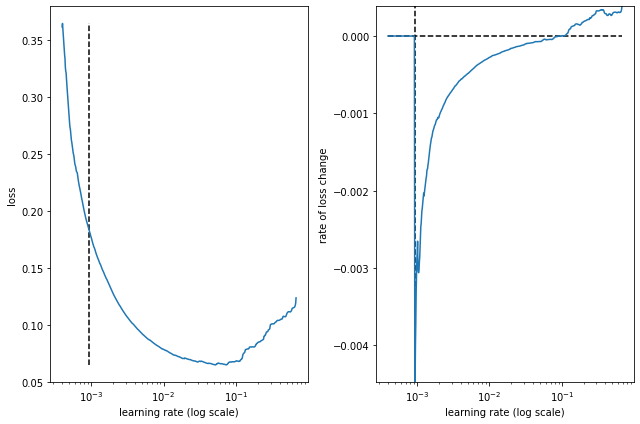

best lr: 0.0009424227 

Epoch 1/5
5881/5881 [==============================] - 10s 1ms/step - loss: 0.5230 - mae: 0.4179


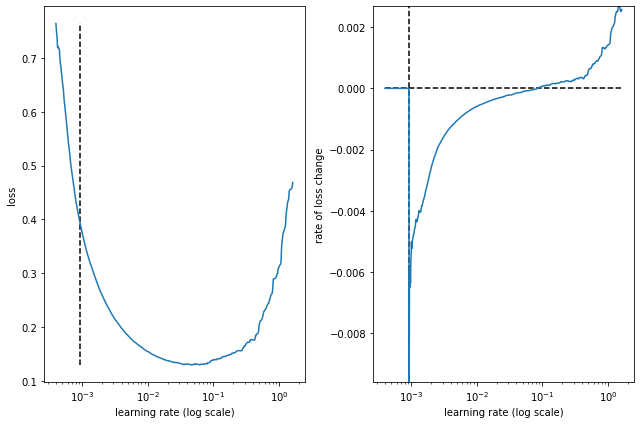

best lr: 0.0009318022 

Model: "lstm_24l_1s_gen"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 24, 1)]           0         
_________________________________________________________________
lstm (LSTM)                  (None, 31)                4092      
_________________________________________________________________
dense (Dense)                (None, 1)                 32        
Total params: 4,124
Trainable params: 4,124
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
5881/5881 - 41s - loss: 0.0151 - mae: 0.0730 - val_loss: 0.0130 - val_mae: 0.0701
Epoch 2/10
5881/5881 - 39s - loss: 0.0111 - mae: 0.0639 - val_loss: 0.0118 - val_mae: 0.0631
Epoch 3/10
5881/5881 - 39s - loss: 0.0108 - mae: 0.0634 - val_loss: 0.0114 - val_mae: 0.0617
Epoch 4/10
5881/5881 - 39s - loss: 0.0106 - mae: 0.0628 - val_loss: 0.0110 -

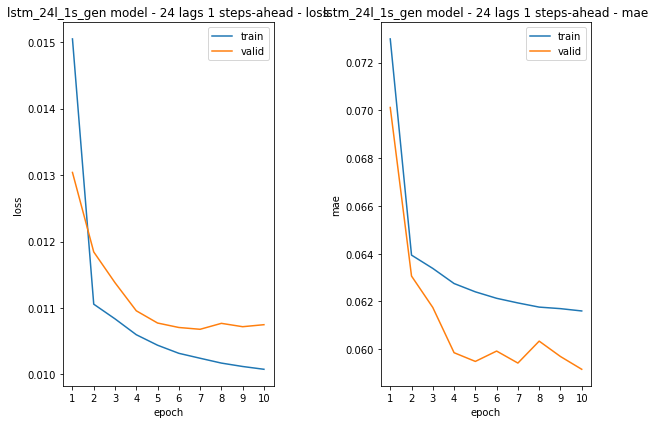

lstm_24l_1s_gen model - 24 lags 1 steps-ahead - train min loss: 0.010077	mae: 0.061604	epoch: 10
lstm_24l_1s_gen model - 24 lags 1 steps-ahead - valid min loss: 0.010679	mae: 0.059421	epoch: 7

Model: "lstm_24l_1s_t2v"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 24, 1)]           0         
_________________________________________________________________
t2v (T2V)                    (None, 24, 34)            873       
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                3264      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 4,154
Trainable params: 4,154
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
5881/5881 - 43s - loss: 0.0171 - mae: 0.07

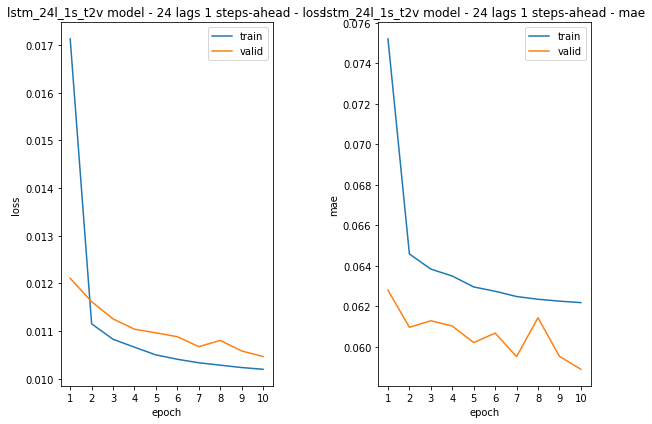

lstm_24l_1s_t2v model - 24 lags 1 steps-ahead - train min loss: 0.010200	mae: 0.062188	epoch: 10
lstm_24l_1s_t2v model - 24 lags 1 steps-ahead - valid min loss: 0.010467	mae: 0.058897	epoch: 10



In [ ]:
SEQ_LEN  = 24
modelgen =     NN(SEQ_LEN, 31, 'lstm_24l_1s_gen')
modelt2v = T2V_NN(SEQ_LEN, 16, 'lstm_24l_1s_t2v')


sum_params = [0.0003, 10, 32, 5, 100, 25]
models['lstm_24l_1s_gen'] = modelgen
lrf = run_lrf(models, ds['train_24l_1s_t2v'],  'lstm_24l_1s_gen',  lrf, sum_params)

models['lstm_24l_1s_t2v'] = modelt2v
lrf = run_lrf(models, ds['train_24l_1s_t2v'],  'lstm_24l_1s_t2v',  lrf, sum_params)


h['lstm_24l_1s_gen'] = run_model(modelgen, ds['train_24l_1s_t2v'], ds['valid_24l_1s_t2v'], epochs = 10)
h['lstm_24l_1s_t2v'] = run_model(modelt2v, ds['train_24l_1s_t2v'], ds['valid_24l_1s_t2v'], epochs = 10)

Very similar results with and without time2vec layer.

---

Next, check time2vec performance on 48 steps ahead forecasts:
  * univariate data again
    * vanilla LSTM for comparison

Epoch 1/5
5880/5880 [==============================] - 10s 1ms/step - loss: 1.5404 - mae: 0.6173


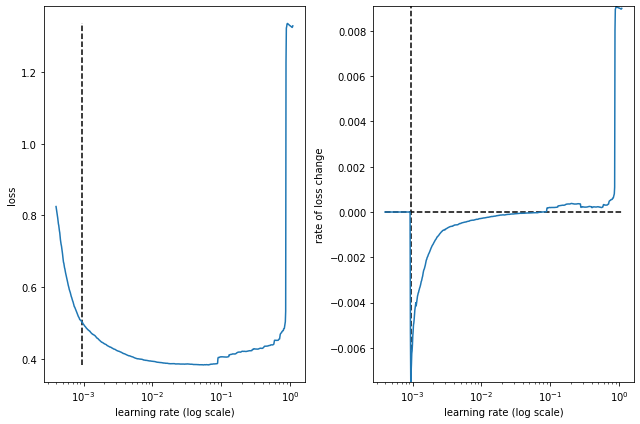

best lr: 0.00094260584 

Epoch 1/5
5880/5880 [==============================] - 11s 2ms/step - loss: 1.6632 - mae: 0.8650


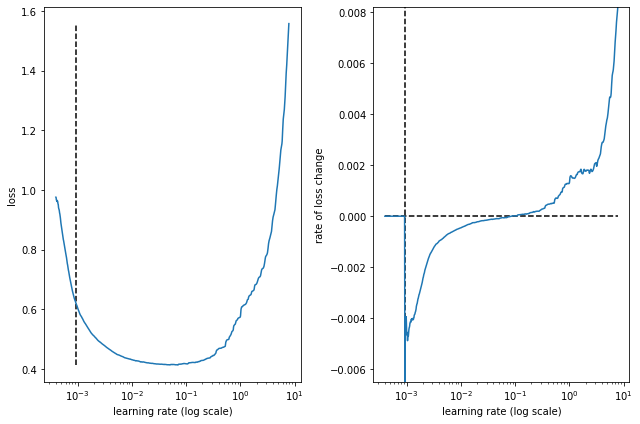

best lr: 0.0009319814 

Model: "lstm_24l_48s_gen"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 24, 1)]           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 31)                4092      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 32        
Total params: 4,124
Trainable params: 4,124
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
5880/5880 - 41s - loss: 0.2980 - mae: 0.4311 - val_loss: 0.3338 - val_mae: 0.4542
Epoch 2/10
5880/5880 - 39s - loss: 0.2882 - mae: 0.4242 - val_loss: 0.3311 - val_mae: 0.4537
Epoch 3/10
5880/5880 - 39s - loss: 0.2862 - mae: 0.4228 - val_loss: 0.3303 - val_mae: 0.4536
Epoch 4/10
5880/5880 - 40s - loss: 0.2852 - mae: 0.4221 - val_loss: 0.3296 

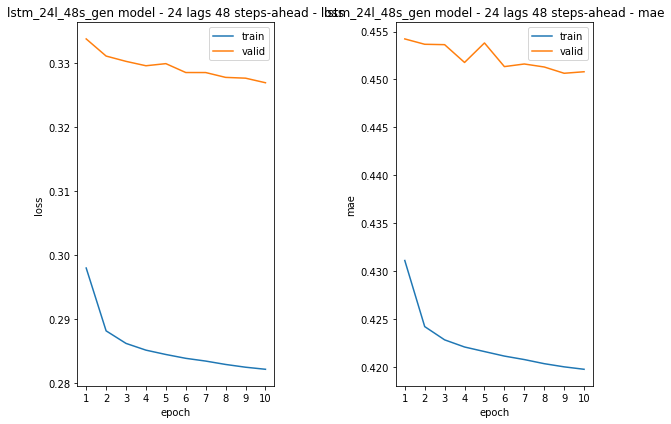

lstm_24l_48s_gen model - 24 lags 48 steps-ahead - train min loss: 0.282209	mae: 0.419761	epoch: 10
lstm_24l_48s_gen model - 24 lags 48 steps-ahead - valid min loss: 0.326926	mae: 0.450809	epoch: 10

Model: "lstm_24l_48s_t2v"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 24, 1)]           0         
_________________________________________________________________
t2v_2 (T2V)                  (None, 24, 34)            873       
_________________________________________________________________
lstm_5 (LSTM)                (None, 16)                3264      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 4,154
Trainable params: 4,154
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
5880/5880 - 43s - loss: 0.2972 - mae

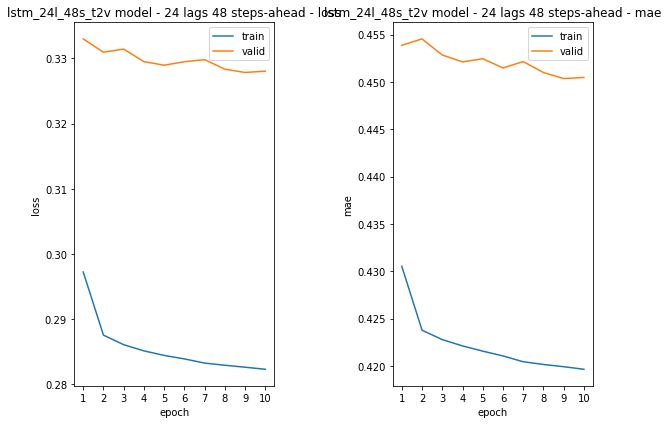

lstm_24l_48s_t2v model - 24 lags 48 steps-ahead - train min loss: 0.282315	mae: 0.419649	epoch: 10
lstm_24l_48s_t2v model - 24 lags 48 steps-ahead - valid min loss: 0.327848	mae: 0.450361	epoch: 9



In [ ]:
SEQ_LEN  = 24
modelgen =     NN(SEQ_LEN, 31, 'lstm_24l_48s_gen')
modelt2v = T2V_NN(SEQ_LEN, 16, 'lstm_24l_48s_t2v')

sum_params = [0.0003, 10, 32, 5, 100, 25]
models['lstm_24l_48s_gen'] = modelgen
lrf = run_lrf(models, ds['train_24l_48s_t2v'],  'lstm_24l_48s_gen',  lrf, sum_params)
models['lstm_24l_48s_t2v'] = modelt2v
lrf = run_lrf(models, ds['train_24l_48s_t2v'],  'lstm_24l_48s_t2v',  lrf, sum_params)

h['lstm_24l_48s_gen'] = run_model(models['lstm_24l_48s_gen'], ds['train_24l_48s_t2v'], ds['valid_24l_48s_t2v'], epochs = 10)
h['lstm_24l_48s_t2v'] = run_model(models['lstm_24l_48s_t2v'], ds['train_24l_48s_t2v'], ds['valid_24l_48s_t2v'], epochs = 10)

I'm not going to expand time2vec testing to the full multi-variate data sets or other horizons.


---

### tbats seasonal components - model building

I compare performance of the tbats components on two multivariate datasets; both single step ahead:
  1. Without mixup
  2. With mixup

Then performance of the tbats components can be compared with the basic daily/yearly sin/cos components.

See also **tbats seasonal components - data preparation** section above.

Create the tbats components datasets:
  * With and without mixup
  * Single step ahead and 48 steps ahead

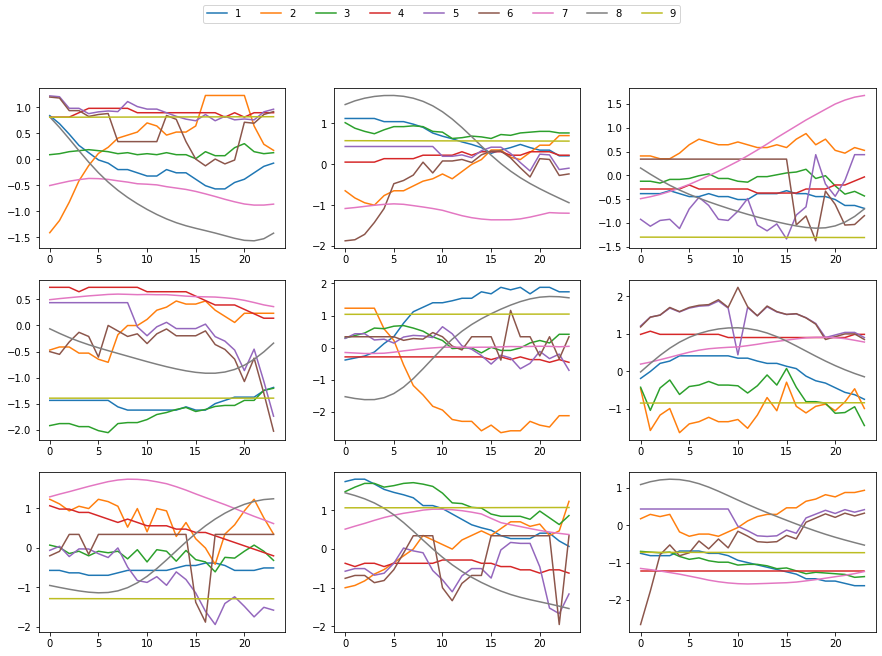

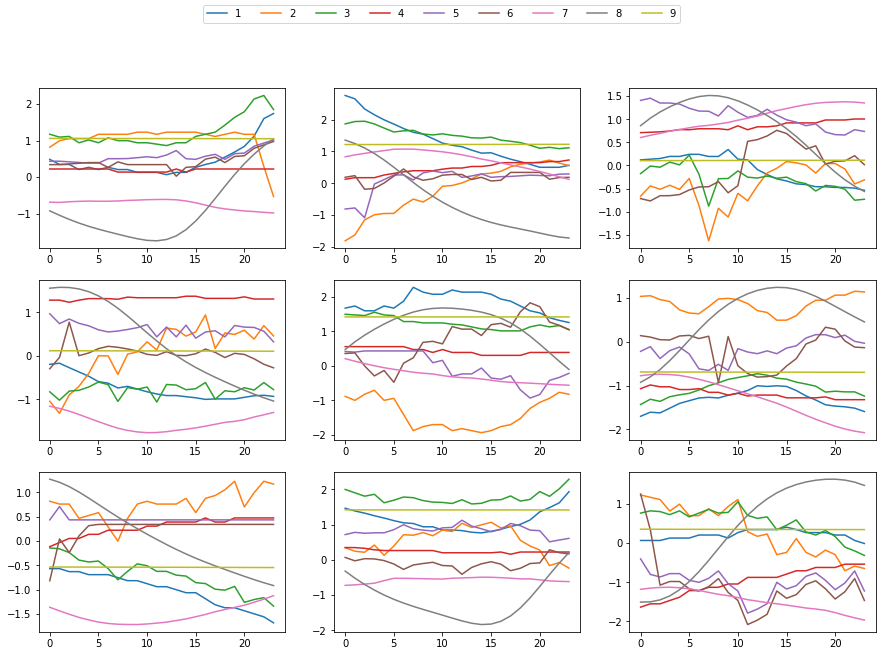

In [16]:
# tbats  single step-ahead

tbats_cols = ['y', 'humidity', 'dew.point', 'pressure', 'wind.x', 'wind.y', \
              'level', 'season1', 'season2']

params_24l_1s_tbats = {'lags':        24, 
                       'steps_ahead':  1,
                       'stride':       1, 
                       'bs':          32,
                       'shuffle':   True,
                       'mix_alpha':    4,
                       'mix_factor':   0,
                       'mix_diff':    48}
ds = make_datasets(ds,
                   train_df.loc[:, tbats_cols],
                   valid_df.loc[:, tbats_cols],
                   test_df.loc[:,  tbats_cols], 
                   params_24l_1s_tbats)
  
params_24l_1s_2m_tbats = {'lags':        24, 
                          'steps_ahead':  1,
                          'stride':       1, 
                          'bs':          32,
                          'shuffle':   True,
                          'mix_alpha':    4,
                          'mix_factor':   2,
                          'mix_diff':    48}
ds = make_datasets(ds,
                   train_df.loc[:, tbats_cols],
                   valid_df.loc[:, tbats_cols],
                   test_df.loc[:,  tbats_cols], 
                   params_24l_1s_2m_tbats)


################################################################################
# tbats 4 steps-ahead

params_24l_4s_tbats = {'lags':        24, 
                       'steps_ahead':  4,
                       'stride':       4, 
                       'bs':          32,
                       'shuffle':   True,
                       'mix_alpha':    4,
                       'mix_factor':   0,
                       'mix_diff':    48}
ds = make_datasets(ds,
                   train_df.loc[:, tbats_cols],
                   valid_df.loc[:, tbats_cols],
                   test_df.loc[:,  tbats_cols], 
                   params_24l_4s_tbats)
  
params_24l_4s_2m_tbats = {'lags':        24, 
                          'steps_ahead':  4,
                          'stride':       4, 
                          'bs':          32,
                          'shuffle':   True,
                          'mix_alpha':    4,
                          'mix_factor':   2,
                          'mix_diff':    48}
ds = make_datasets(ds,
                   train_df.loc[:, tbats_cols],
                   valid_df.loc[:, tbats_cols],
                   test_df.loc[:,  tbats_cols], 
                   params_24l_4s_2m_tbats)


################################################################################
# tbats 48 steps-ahead

params_24l_48s_tbats = {'lags':        24, 
                        'steps_ahead': 48,
                        'stride':      48, 
                        'bs':          32,
                        'shuffle':   True,
                        'mix_alpha':    4,
                        'mix_factor':   0,
                        'mix_diff':    48}
ds = make_datasets(ds,
                   train_df.loc[:, tbats_cols],
                   valid_df.loc[:, tbats_cols],
                   test_df.loc[:,  tbats_cols], 
                   params_24l_48s_tbats)
  
params_24l_48s_2m_tbats = {'lags':        24, 
                           'steps_ahead': 48,
                           'stride':      48, 
                           'bs':          32,
                           'shuffle':   True,
                           'mix_alpha':    4,
                           'mix_factor':   2,
                           'mix_diff':    48}
ds = make_datasets(ds,
                   train_df.loc[:, tbats_cols],
                   valid_df.loc[:, tbats_cols],
                   test_df.loc[:,  tbats_cols], 
                   params_24l_48s_2m_tbats)

plot_dataset_examples(ds['train_24l_1s_tbats'])
plot_dataset_examples(ds['train_24l_1s_2m_tbats'])
#plot_dataset_examples(ds['train_24l_1s_tbats'])

Plots seem to be acceptable.

---

First, check tbats components single step ahead with and without mixup:
  * Create models
  * Find optimal learning rates
  * Train and validate models


Epoch 1/5
5881/5881 [==============================] - 10s 1ms/step - loss: 0.9330 - mae: 0.5077


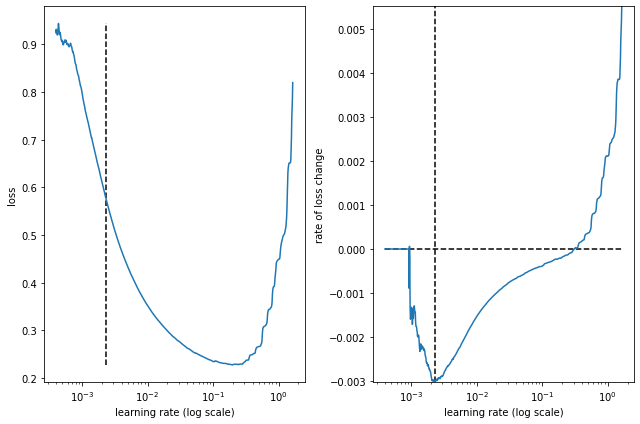

best lr: 0.0023334986 

Model: "lstm_24l_1s_tbats"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 16)                1664      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 17        
Total params: 1,681
Trainable params: 1,681
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
5881/5881 - 42s - loss: 0.0177 - mae: 0.0732 - val_loss: 0.0110 - val_mae: 0.0612
Epoch 2/10
5881/5881 - 41s - loss: 0.0100 - mae: 0.0619 - val_loss: 0.0108 - val_mae: 0.0620
Epoch 3/10
5881/5881 - 40s - loss: 0.0098 - mae: 0.0613 - val_loss: 0.0107 - val_mae: 0.0613
Epoch 4/10
5881/5881 - 41s - loss: 0.0097 - mae: 0.0610 - val_loss: 0.0103 - val_mae: 0.0592
Epoch 5/10
5881/5881 - 41s - loss: 0.0096 - mae: 0.0606 - val_loss: 0.0104 - val_mae: 0.0598
Epoch 6/10
5881/5881

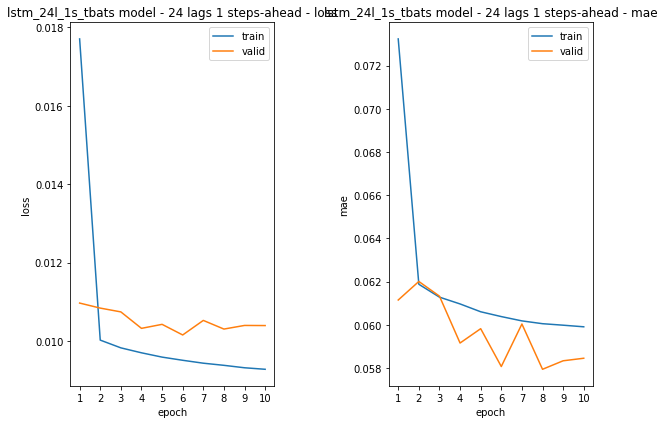

lstm_24l_1s_tbats model - 24 lags 1 steps-ahead - train min loss: 0.009278	mae: 0.059911	epoch: 10
lstm_24l_1s_tbats model - 24 lags 1 steps-ahead - valid min loss: 0.010154	mae: 0.058073	epoch: 6

Epoch 1/5
17641/17641 [==============================] - 21s 1ms/step - loss: 0.1598 - mae: 0.2373


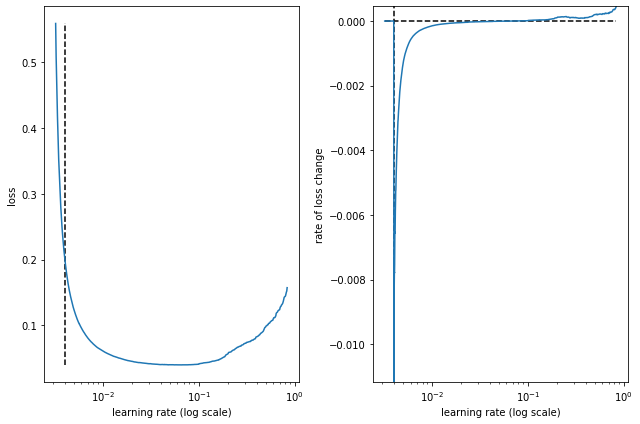

best lr: 0.0040265047 

Model: "lstm_24l_1s_2m_tbats"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 16)                1664      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 17        
Total params: 1,681
Trainable params: 1,681
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
17641/17641 - 113s - loss: 0.0091 - mae: 0.0571 - val_loss: 0.0105 - val_mae: 0.0597
Epoch 2/10
17641/17641 - 112s - loss: 0.0072 - mae: 0.0531 - val_loss: 0.0111 - val_mae: 0.0632
Epoch 3/10
17641/17641 - 111s - loss: 0.0070 - mae: 0.0523 - val_loss: 0.0104 - val_mae: 0.0587
Epoch 4/10
17641/17641 - 111s - loss: 0.0069 - mae: 0.0519 - val_loss: 0.0103 - val_mae: 0.0581
Epoch 5/10
17641/17641 - 111s - loss: 0.0069 - mae: 0.0516 - val_loss: 0.0101 - val_mae: 0.0582
Ep

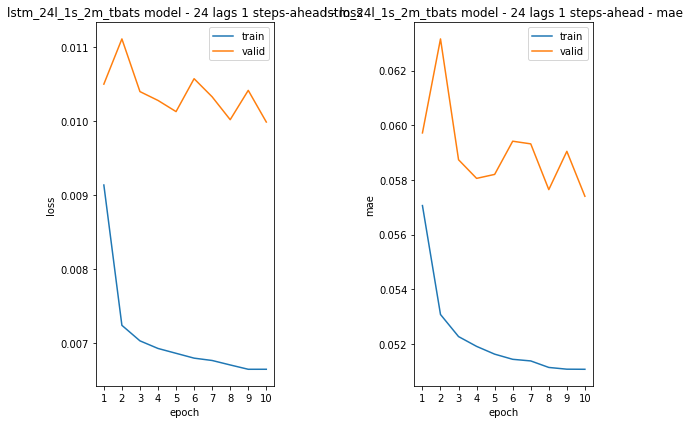

lstm_24l_1s_2m_tbats model - 24 lags 1 steps-ahead - train min loss: 0.006647	mae: 0.051077	epoch: 9
lstm_24l_1s_2m_tbats model - 24 lags 1 steps-ahead - valid min loss: 0.009984	mae: 0.057403	epoch: 10



In [18]:
models['lstm_24l_1s_tbats'] = build_vanilla_lstm_model('lstm_24l_1s_tbats', 
                                                       ds['train_24l_1s_tbats'], 
                                                       feat_maps)
sum_params = [0.0003, 10, 32, 5, 100, 25]
lrf = run_lrf(models, ds['train_24l_1s_tbats'],  'lstm_24l_1s_tbats',  lrf, sum_params)
h['lstm_24l_1s_tbats'] = run_model(models['lstm_24l_1s_tbats'], ds['train_24l_1s_tbats'], ds['valid_24l_1s_tbats'], epochs = 10)


models['lstm_24l_1s_2m_tbats'] = build_vanilla_lstm_model('lstm_24l_1s_2m_tbats', 
                                                          ds['train_24l_1s_2m_tbats'], 
                                                          feat_maps)
sum_params = [0.003, 10, 32, 5, 100, 25]
lrf = run_lrf(models, ds['train_24l_1s_2m_tbats'],  'lstm_24l_1s_2m_tbats',  lrf, sum_params)
h['lstm_24l_1s_2m_tbats'] = run_model(models['lstm_24l_1s_2m_tbats'], ds['train_24l_1s_2m_tbats'], ds['valid_24l_1s_2m_tbats'], epochs = 10)

...

---

Second, check 4 steps ahead with and without mixup:
  * Create models
  * Find optimal learning rates
  * Train and validate models

Epoch 1/5
5881/5881 [==============================] - 10s 1ms/step - loss: 1.0212 - mae: 0.5479


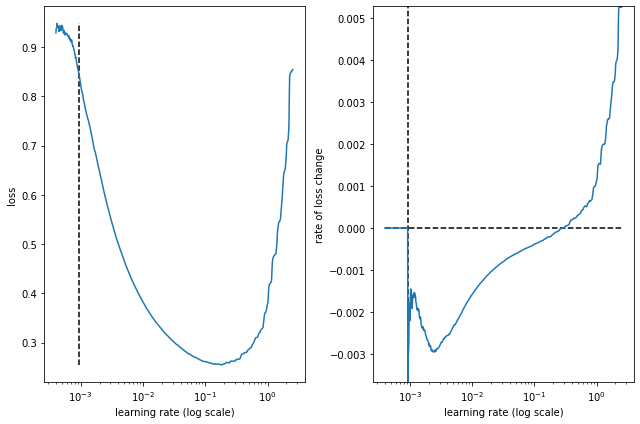

best lr: 0.0009318022 

Model: "lstm_24l_4s_tbats"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 16)                1664      
_________________________________________________________________
dense_9 (Dense)              (None, 4)                 68        
Total params: 1,732
Trainable params: 1,732
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
5881/5881 - 42s - loss: 0.0414 - mae: 0.1216 - val_loss: 0.0232 - val_mae: 0.0951
Epoch 2/10
5881/5881 - 40s - loss: 0.0213 - mae: 0.0949 - val_loss: 0.0222 - val_mae: 0.0929
Epoch 3/10
5881/5881 - 41s - loss: 0.0206 - mae: 0.0934 - val_loss: 0.0217 - val_mae: 0.0917
Epoch 4/10
5881/5881 - 41s - loss: 0.0203 - mae: 0.0928 - val_loss: 0.0215 - val_mae: 0.0914
Epoch 5/10
5881/5881 - 40s - loss: 0.0200 - mae: 0.0922 - val_loss: 0.0214 - val_mae: 0.0910
Epoch 6/10
5881/5881

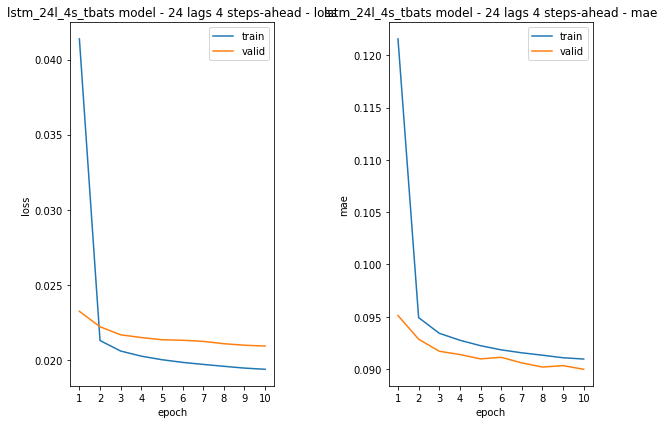

lstm_24l_4s_tbats model - 24 lags 4 steps-ahead - train min loss: 0.019390	mae: 0.090955	epoch: 10
lstm_24l_4s_tbats model - 24 lags 4 steps-ahead - valid min loss: 0.020937	mae: 0.089976	epoch: 10

Epoch 1/5
17641/17641 [==============================] - 21s 1ms/step - loss: 0.2032 - mae: 0.2756


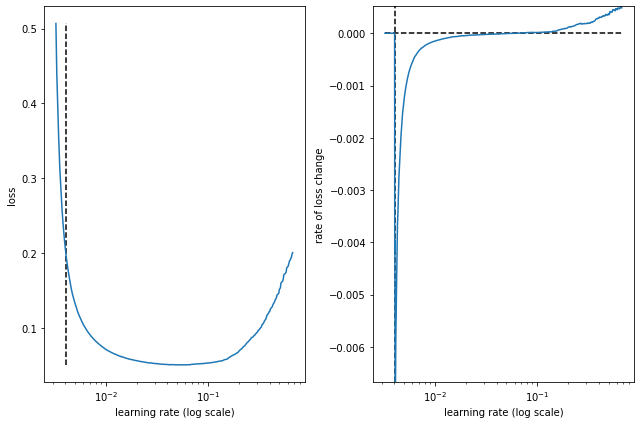

best lr: 0.00408619 

Model: "lstm_24l_4s_2m_tbats"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 16)                1664      
_________________________________________________________________
dense_10 (Dense)             (None, 4)                 68        
Total params: 1,732
Trainable params: 1,732
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
17641/17641 - 115s - loss: 0.0169 - mae: 0.0839 - val_loss: 0.0219 - val_mae: 0.0932
Epoch 2/10
17641/17641 - 113s - loss: 0.0141 - mae: 0.0784 - val_loss: 0.0216 - val_mae: 0.0913
Epoch 3/10
17641/17641 - 113s - loss: 0.0138 - mae: 0.0774 - val_loss: 0.0217 - val_mae: 0.0925
Epoch 4/10
17641/17641 - 114s - loss: 0.0136 - mae: 0.0768 - val_loss: 0.0227 - val_mae: 0.0967
Epoch 5/10
17641/17641 - 114s - loss: 0.0134 - mae: 0.0764 - val_loss: 0.0214 - val_mae: 0.0915
Epoc

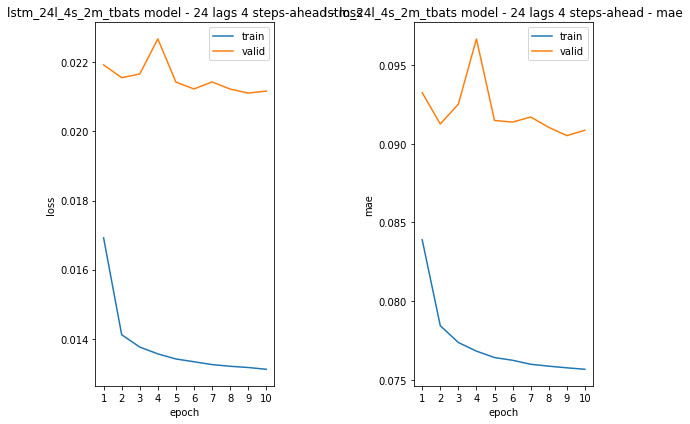

lstm_24l_4s_2m_tbats model - 24 lags 4 steps-ahead - train min loss: 0.013119	mae: 0.075665	epoch: 10
lstm_24l_4s_2m_tbats model - 24 lags 4 steps-ahead - valid min loss: 0.021110	mae: 0.090517	epoch: 9



In [19]:
models['lstm_24l_4s_tbats'] = build_vanilla_lstm_model('lstm_24l_4s_tbats', 
                                                       ds['train_24l_4s_tbats'], 
                                                       feat_maps)
sum_params = [0.0003, 10, 32, 5, 100, 25]
lrf = run_lrf(models, ds['train_24l_4s_tbats'],  'lstm_24l_4s_tbats',  lrf, sum_params)
h['lstm_24l_4s_tbats'] = run_model(models['lstm_24l_4s_tbats'], ds['train_24l_4s_tbats'], ds['valid_24l_4s_tbats'], epochs = 10)


models['lstm_24l_4s_2m_tbats'] = build_vanilla_lstm_model('lstm_24l_4s_2m_tbats', 
                                                          ds['train_24l_4s_2m_tbats'], 
                                                          feat_maps)
sum_params = [0.003, 10, 32, 5, 100, 25]
lrf = run_lrf(models, ds['train_24l_4s_2m_tbats'],  'lstm_24l_4s_2m_tbats',  lrf, sum_params)
h['lstm_24l_4s_2m_tbats'] = run_model(models['lstm_24l_4s_2m_tbats'], ds['train_24l_4s_2m_tbats'], ds['valid_24l_4s_2m_tbats'], epochs = 10)

...

---

Third, check 48 steps ahead with and without mixup:
  * Create models
  * Find optimal learning rates
  * Train and validate models

Epoch 1/5
5880/5880 [==============================] - 11s 1ms/step - loss: 1.4462 - mae: 0.7184


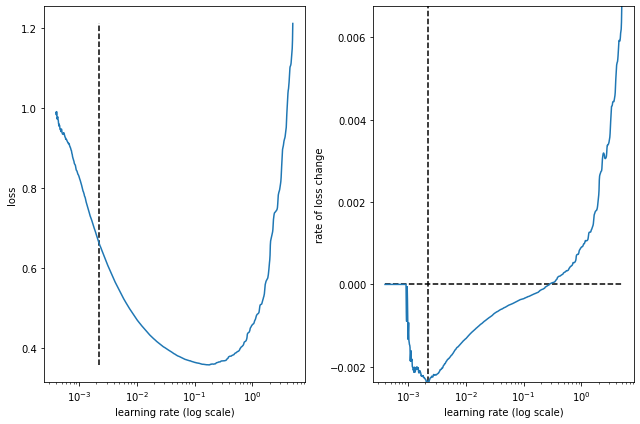

best lr: 0.0022056918 

Model: "lstm_24l_48s_tbats"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 16)                1664      
_________________________________________________________________
dense_11 (Dense)             (None, 48)                816       
Total params: 2,480
Trainable params: 2,480
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
5880/5880 - 43s - loss: 0.1332 - mae: 0.2744 - val_loss: 0.1325 - val_mae: 0.2697
Epoch 2/10
5880/5880 - 41s - loss: 0.1140 - mae: 0.2543 - val_loss: 0.1320 - val_mae: 0.2702
Epoch 3/10
5880/5880 - 40s - loss: 0.1115 - mae: 0.2513 - val_loss: 0.1288 - val_mae: 0.2650
Epoch 4/10
5880/5880 - 41s - loss: 0.1101 - mae: 0.2496 - val_loss: 0.1288 - val_mae: 0.2654
Epoch 5/10
5880/5880 - 41s - loss: 0.1090 - mae: 0.2483 - val_loss: 0.1284 - val_mae: 0.2651
Epoch 6/10
5880/588

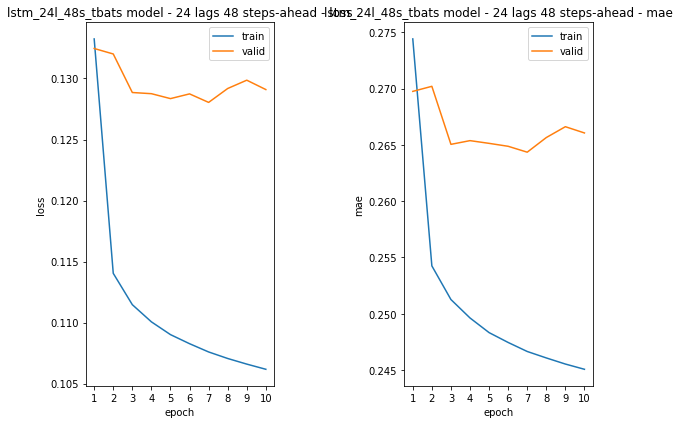

lstm_24l_48s_tbats model - 24 lags 48 steps-ahead - train min loss: 0.106174	mae: 0.245074	epoch: 10
lstm_24l_48s_tbats model - 24 lags 48 steps-ahead - valid min loss: 0.128040	mae: 0.264350	epoch: 7

Epoch 1/5
17640/17640 [==============================] - 26s 1ms/step - loss: 0.5708 - mae: 0.5019


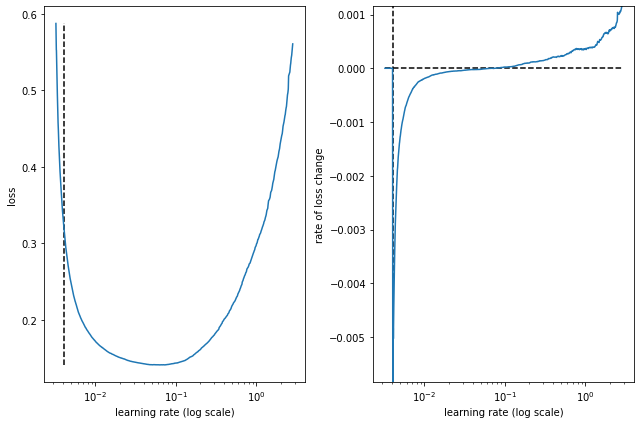

best lr: 0.004038442 

Model: "lstm_24l_48s_2m_tbats"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 16)                1664      
_________________________________________________________________
dense_12 (Dense)             (None, 48)                816       
Total params: 2,480
Trainable params: 2,480
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
17640/17640 - 117s - loss: 0.0845 - mae: 0.2159 - val_loss: 0.1300 - val_mae: 0.2651
Epoch 2/10
17640/17640 - 115s - loss: 0.0772 - mae: 0.2063 - val_loss: 0.1294 - val_mae: 0.2644
Epoch 3/10
17640/17640 - 114s - loss: 0.0761 - mae: 0.2046 - val_loss: 0.1277 - val_mae: 0.2618
Epoch 4/10
17640/17640 - 114s - loss: 0.0754 - mae: 0.2036 - val_loss: 0.1275 - val_mae: 0.2615
Epoch 5/10
17640/17640 - 115s - loss: 0.0749 - mae: 0.2030 - val_loss: 0.1264 - val_mae: 0.2605
Ep

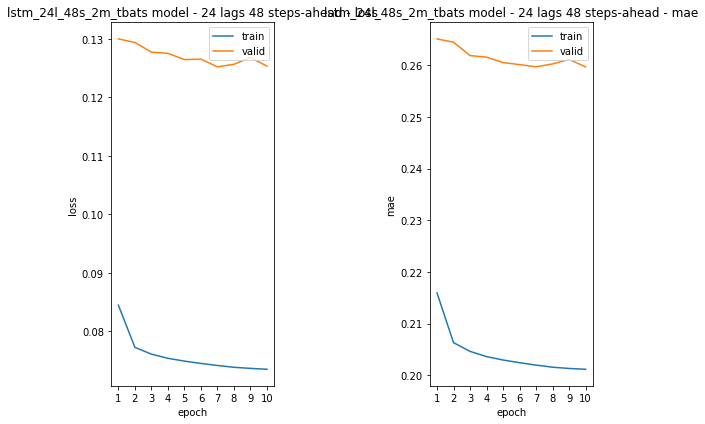

lstm_24l_48s_2m_tbats model - 24 lags 48 steps-ahead - train min loss: 0.073502	mae: 0.201175	epoch: 10
lstm_24l_48s_2m_tbats model - 24 lags 48 steps-ahead - valid min loss: 0.125198	mae: 0.259661	epoch: 7



In [20]:
models['lstm_24l_48s_tbats'] = build_vanilla_lstm_model('lstm_24l_48s_tbats', 
                                                        ds['train_24l_48s_tbats'], 
                                                        feat_maps)
sum_params = [0.0003, 10, 32, 5, 100, 25]
lrf = run_lrf(models, ds['train_24l_48s_tbats'],  'lstm_24l_48s_tbats',  lrf, sum_params)
h['lstm_24l_48s_tbats'] = run_model(models['lstm_24l_48s_tbats'], ds['train_24l_48s_tbats'], ds['valid_24l_48s_tbats'], epochs = 10)


models['lstm_24l_48s_2m_tbats'] = build_vanilla_lstm_model('lstm_24l_48s_2m_tbats', 
                                                           ds['train_24l_48s_2m_tbats'], 
                                                           feat_maps)
sum_params = [0.003, 10, 32, 5, 100, 25]
lrf = run_lrf(models, ds['train_24l_48s_2m_tbats'],  'lstm_24l_48s_2m_tbats',  lrf, sum_params)
h['lstm_24l_48s_2m_tbats'] = run_model(models['lstm_24l_48s_2m_tbats'], ds['train_24l_48s_2m_tbats'], ds['valid_24l_48s_2m_tbats'], epochs = 10)

...

**TODO** Compare performance of tbats components with daily/yearly sin/cos components.

...

---

### Stacked LSTM

A stacked LSTM architecture is simply a LSTM model comprised of multiple LSTM layers.  It should allow greater model complexity.  

Assuming a two layer stack, then the first LSTM layer provides a sequence output rather than a single value output to the second LSTM layer.

**TODO** Include illustrative figure

First, single step ahead with mixup:
  * Create model
  * Find optimal learning rate
  * Train and validate model

Epoch 1/5
17641/17641 [==============================] - 42s 2ms/step - loss: 0.5095 - mae: 0.4036


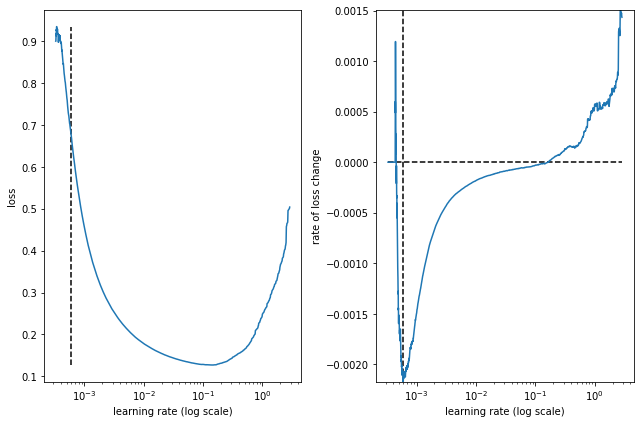

best lr: 0.00059445255 

Model: "lstm_24l_1s_2m_s"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 24, 16)            1728      
_________________________________________________________________
lstm_14 (LSTM)               (None, 16)                2112      
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 17        
Total params: 3,857
Trainable params: 3,857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
17641/17641 - 194s - loss: 0.0158 - mae: 0.0669 - val_loss: 0.0108 - val_mae: 0.0599
Epoch 2/10
17641/17641 - 186s - loss: 0.0070 - mae: 0.0512 - val_loss: 0.0102 - val_mae: 0.0576
Epoch 3/10
17641/17641 - 188s - loss: 0.0068 - mae: 0.0505 - val_loss: 0.0100 - val_mae: 0.0572
Epoch 4/10
17641/17641 - 185s - loss: 0.0067 - mae: 0.0501 - val_

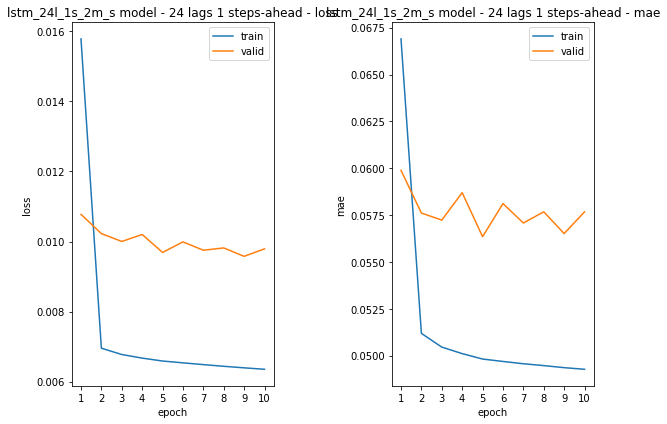

lstm_24l_1s_2m_s model - 24 lags 1 steps-ahead - train min loss: 0.006354	mae: 0.049274	epoch: 10
lstm_24l_1s_2m_s model - 24 lags 1 steps-ahead - valid min loss: 0.009578	mae: 0.056516	epoch: 9



In [21]:
def build_stacked_lstm_model(name, data, n_feature_maps = 8):
    in_shape, out_shape = get_io_shapes(data)
    out_steps = out_shape[0]

    lstm = Sequential(name = name)
    lstm.add(InputLayer(input_shape = in_shape))

    # Shape [batch, time, features] => [batch, n_feature_maps]
    lstm.add(LSTM(n_feature_maps, return_sequences = True))
    lstm.add(LSTM(n_feature_maps))

    # Shape => [batch, out_steps]
    lstm.add(Dense(out_steps,
                   kernel_initializer = tf.initializers.zeros()))

    return lstm


models['lstm_24l_1s_2m_s'] = build_stacked_lstm_model('lstm_24l_1s_2m_s', 
                                                      ds['train_24l_1s_2m'], 
                                                      feat_maps)
sum_params = [0.0003, 10, 32, 5, 100, 25]
lrf = run_lrf(models, ds['train_24l_1s_2m'],  'lstm_24l_1s_2m_s',  lrf, sum_params)
h['lstm_24l_1s_2m_s'] = run_model(models['lstm_24l_1s_2m_s'], ds['train_24l_1s_2m'], ds['valid_24l_1s_2m'], epochs = 5)

...

---

Second, 4 steps ahead with mixup:
  * Create model
  * Find optimal learning rate
  * Train and validate model

Epoch 1/5
17641/17641 [==============================] - 43s 2ms/step - loss: 0.5506 - mae: 0.4326


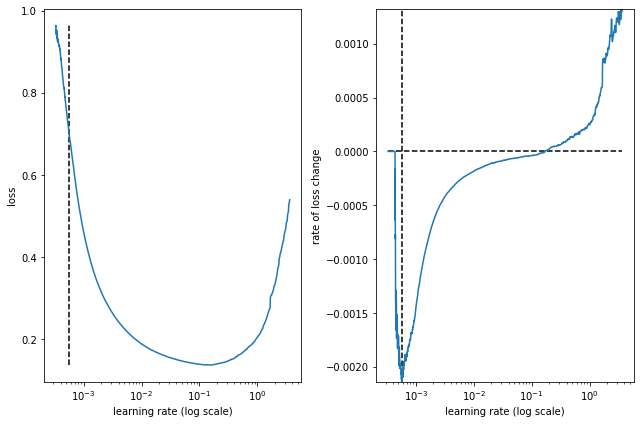

best lr: 0.0005681027 

Model: "lstm_24l_4s_2m_s"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 24, 16)            1728      
_________________________________________________________________
lstm_16 (LSTM)               (None, 16)                2112      
_________________________________________________________________
dense_14 (Dense)             (None, 4)                 68        
Total params: 3,908
Trainable params: 3,908
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
17641/17641 - 190s - loss: 0.0246 - mae: 0.0952 - val_loss: 0.0215 - val_mae: 0.0927
Epoch 2/5
17641/17641 - 182s - loss: 0.0146 - mae: 0.0783 - val_loss: 0.0203 - val_mae: 0.0887
Epoch 3/5
17641/17641 - 186s - loss: 0.0142 - mae: 0.0773 - val_loss: 0.0202 - val_mae: 0.0884
Epoch 4/5
17641/17641 - 186s - loss: 0.0140 - mae: 0.0767 - val_loss:

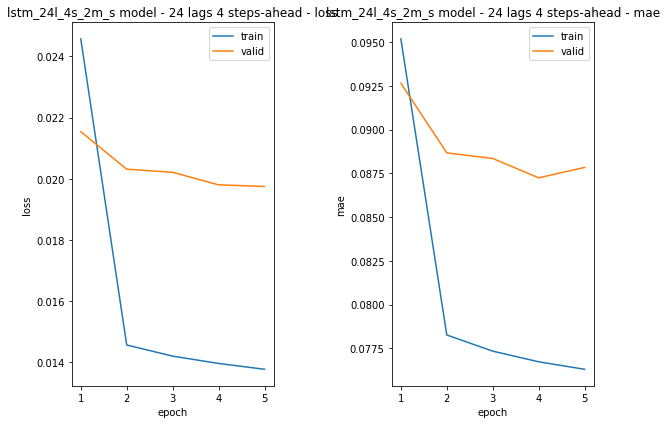

lstm_24l_4s_2m_s model - 24 lags 4 steps-ahead - train min loss: 0.013773	mae: 0.076300	epoch: 5
lstm_24l_4s_2m_s model - 24 lags 4 steps-ahead - valid min loss: 0.019749	mae: 0.087840	epoch: 5



In [22]:
models['lstm_24l_4s_2m_s'] = build_stacked_lstm_model('lstm_24l_4s_2m_s', 
                                                      ds['train_24l_4s_2m'], 
                                                      feat_maps)

sum_params = [0.0003, 10, 32, 5, 100, 25]
lrf = run_lrf(models, ds['train_24l_4s_2m'], 'lstm_24l_4s_2m_s', lrf, sum_params)

h['lstm_24l_4s_2m_s'] = run_model(models['lstm_24l_4s_2m_s'], ds['train_24l_4s_2m'], ds['valid_24l_4s_2m'], epochs = 5)

...

---

Stacked LSTM 12 steps ahead with mixup:
  * Create model
  * Find optimal learning rate
  * Train and validate model

Epoch 1/5
17641/17641 [==============================] - 39s 2ms/step - loss: 0.6736 - mae: 0.4505


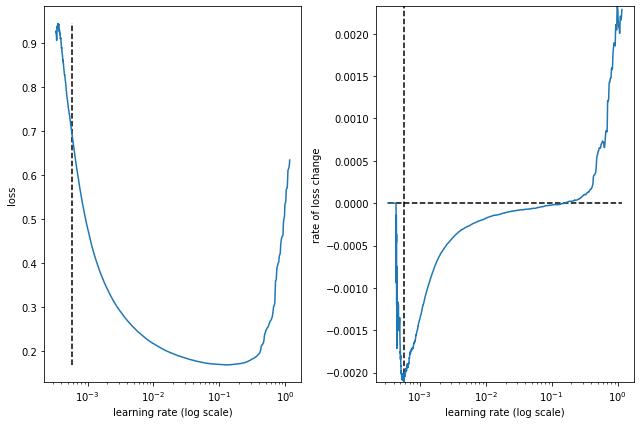

best lr: 0.0005724118 

Model: "lstm_24l_12s_2m_s"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_19 (LSTM)               (None, 24, 16)            1728      
_________________________________________________________________
lstm_20 (LSTM)               (None, 16)                2112      
_________________________________________________________________
dense_16 (Dense)             (None, 12)                204       
Total params: 4,044
Trainable params: 4,044
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
17641/17641 - 192s - loss: 0.0484 - mae: 0.1499 - val_loss: 0.0513 - val_mae: 0.1536
Epoch 2/5
17641/17641 - 189s - loss: 0.0344 - mae: 0.1290 - val_loss: 0.0491 - val_mae: 0.1495
Epoch 3/5
17641/17641 - 190s - loss: 0.0331 - mae: 0.1267 - val_loss: 0.0489 - val_mae: 0.1499
Epoch 4/5
17641/17641 - 189s - loss: 0.0323 - mae: 0.1254 - val_loss

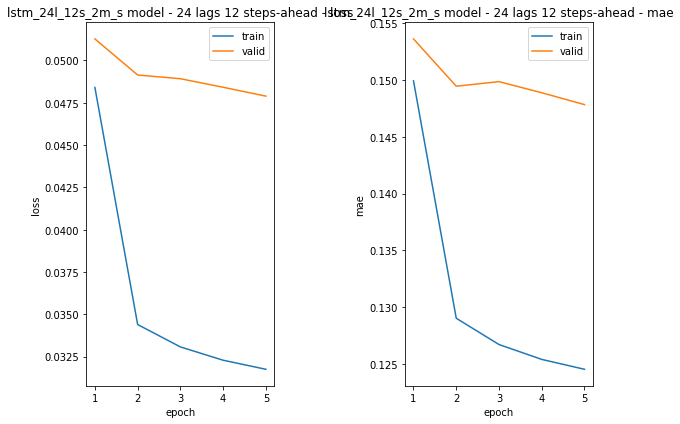

lstm_24l_12s_2m_s model - 24 lags 12 steps-ahead - train min loss: 0.031756	mae: 0.124538	epoch: 5
lstm_24l_12s_2m_s model - 24 lags 12 steps-ahead - valid min loss: 0.047888	mae: 0.147836	epoch: 5



In [51]:
models['lstm_24l_12s_2m_s'] = build_stacked_lstm_model('lstm_24l_12s_2m_s', 
                                                        ds['train_24l_12s_2m'], 
                                                        feat_maps)

sum_params = [0.0003, 10, 32, 5, 100, 25]
lrf = run_lrf(models, ds['train_24l_12s_2m'], 'lstm_24l_12s_2m_s', lrf, sum_params)

h['lstm_24l_12s_2m_s'] = run_model(models['lstm_24l_12s_2m_s'], ds['train_24l_12s_2m'], ds['valid_24l_12s_2m'], epochs = 5)

...

---

Stacked LSTM 24 steps ahead with mixup:
  * Create model
  * Find optimal learning rate
  * Train and validate model

Epoch 1/5
17641/17641 [==============================] - 40s 2ms/step - loss: 0.7806 - mae: 0.5081


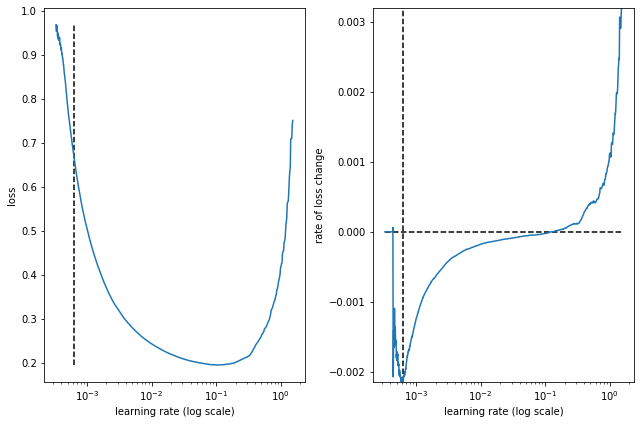

best lr: 0.00061734207 

Model: "lstm_24l_24s_2m_s"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_21 (LSTM)               (None, 24, 16)            1728      
_________________________________________________________________
lstm_22 (LSTM)               (None, 16)                2112      
_________________________________________________________________
dense_17 (Dense)             (None, 24)                408       
Total params: 4,248
Trainable params: 4,248
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
17641/17641 - 195s - loss: 0.0668 - mae: 0.1847 - val_loss: 0.0834 - val_mae: 0.2037
Epoch 2/5
17641/17641 - 189s - loss: 0.0503 - mae: 0.1620 - val_loss: 0.0815 - val_mae: 0.2020
Epoch 3/5
17641/17641 - 188s - loss: 0.0485 - mae: 0.1589 - val_loss: 0.0800 - val_mae: 0.1988
Epoch 4/5
17641/17641 - 193s - loss: 0.0474 - mae: 0.1571 - val_los

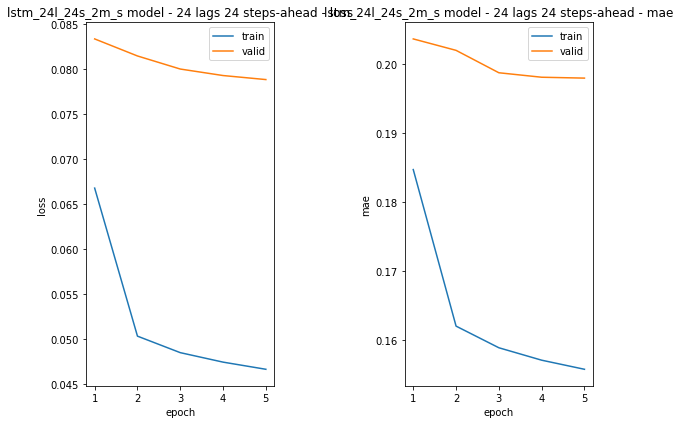

lstm_24l_24s_2m_s model - 24 lags 24 steps-ahead - train min loss: 0.046619	mae: 0.155739	epoch: 5
lstm_24l_24s_2m_s model - 24 lags 24 steps-ahead - valid min loss: 0.078840	mae: 0.198000	epoch: 5



In [52]:
models['lstm_24l_24s_2m_s'] = build_stacked_lstm_model('lstm_24l_24s_2m_s', 
                                                        ds['train_24l_24s_2m'], 
                                                        feat_maps)

sum_params = [0.0003, 10, 32, 5, 100, 25]
lrf = run_lrf(models, ds['train_24l_24s_2m'], 'lstm_24l_24s_2m_s', lrf, sum_params)

h['lstm_24l_24s_2m_s'] = run_model(models['lstm_24l_24s_2m_s'], ds['train_24l_24s_2m'], ds['valid_24l_24s_2m'], epochs = 5)

...

---

Stacked LSTM 96 steps ahead with mixup:
  * Create model
  * Find optimal learning rate
  * Train and validate model

Epoch 1/5
17638/17638 [==============================] - 43s 2ms/step - loss: 1.0197 - mae: 0.5701


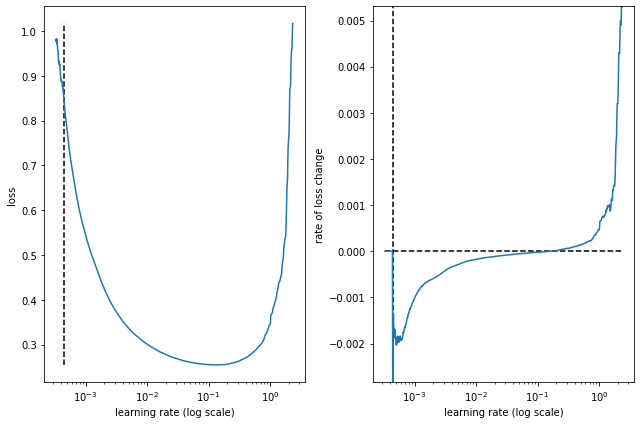

best lr: 0.00044108013 

Model: "lstm_24l_96s_2m_s"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_23 (LSTM)               (None, 24, 16)            1728      
_________________________________________________________________
lstm_24 (LSTM)               (None, 16)                2112      
_________________________________________________________________
dense_18 (Dense)             (None, 96)                1632      
Total params: 5,472
Trainable params: 5,472
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
17638/17638 - 195s - loss: 0.1362 - mae: 0.2788 - val_loss: 0.1906 - val_mae: 0.3316
Epoch 2/5
17638/17638 - 193s - loss: 0.1142 - mae: 0.2551 - val_loss: 0.1884 - val_mae: 0.3290
Epoch 3/5
17638/17638 - 192s - loss: 0.1107 - mae: 0.2505 - val_loss: 0.1861 - val_mae: 0.3266
Epoch 4/5
17638/17638 - 192s - loss: 0.1082 - mae: 0.2476 - val_los

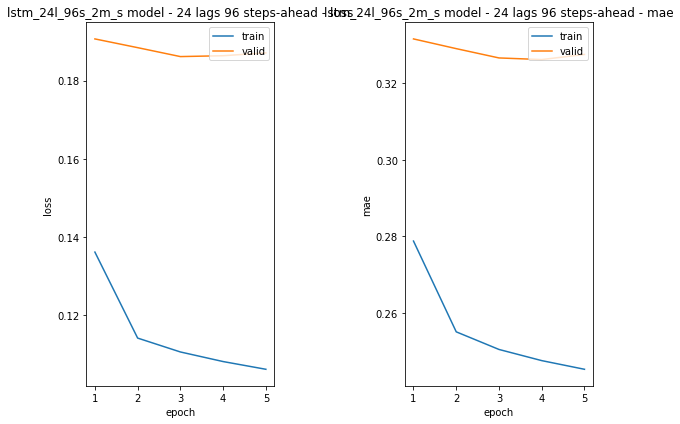

lstm_24l_96s_2m_s model - 24 lags 96 steps-ahead - train min loss: 0.106257	mae: 0.245337	epoch: 5
lstm_24l_96s_2m_s model - 24 lags 96 steps-ahead - valid min loss: 0.186110	mae: 0.326612	epoch: 3



In [55]:
models['lstm_24l_96s_2m_s'] = build_stacked_lstm_model('lstm_24l_96s_2m_s', 
                                                        ds['train_24l_96s_2m'], 
                                                        feat_maps)

sum_params = [0.0003, 10, 32, 5, 100, 25]
lrf = run_lrf(models, ds['train_24l_96s_2m'], 'lstm_24l_96s_2m_s', lrf, sum_params)

h['lstm_24l_96s_2m_s'] = run_model(models['lstm_24l_96s_2m_s'], ds['train_24l_96s_2m'], ds['valid_24l_96s_2m'], epochs = 5)

...

---

Third, stacked LSTM 48 steps ahead with mixup:
  * Create model
  * Find optimal learning rate
  * Train and validate model

Epoch 1/5
17640/17640 [==============================] - 41s 2ms/step - loss: 0.8875 - mae: 0.5446


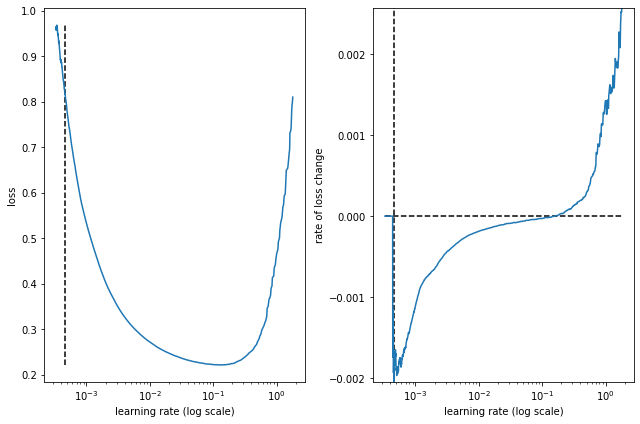

best lr: 0.00045977873 

Model: "lstm_24l_48s_2m_s"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_17 (LSTM)               (None, 24, 16)            1728      
_________________________________________________________________
lstm_18 (LSTM)               (None, 16)                2112      
_________________________________________________________________
dense_15 (Dense)             (None, 48)                816       
Total params: 4,656
Trainable params: 4,656
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
17640/17640 - 190s - loss: 0.0978 - mae: 0.2314 - val_loss: 0.1311 - val_mae: 0.2657
Epoch 2/5
17640/17640 - 185s - loss: 0.0770 - mae: 0.2061 - val_loss: 0.1269 - val_mae: 0.2601
Epoch 3/5
17640/17640 - 188s - loss: 0.0746 - mae: 0.2022 - val_loss: 0.1243 - val_mae: 0.2568
Epoch 4/5
17640/17640 - 189s - loss: 0.0733 - mae: 0.2001 - val_los

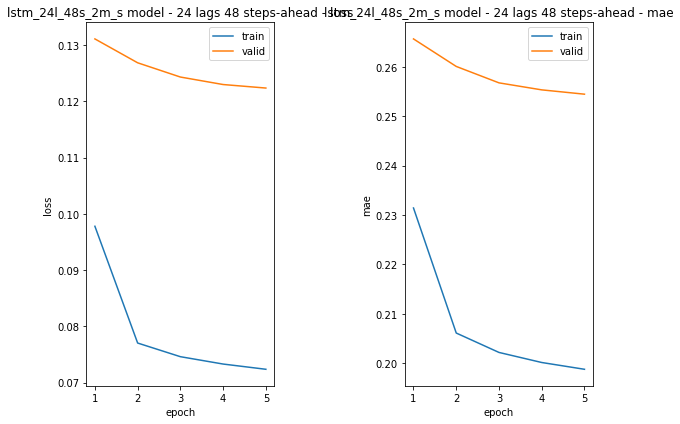

lstm_24l_48s_2m_s model - 24 lags 48 steps-ahead - train min loss: 0.072383	mae: 0.198755	epoch: 5
lstm_24l_48s_2m_s model - 24 lags 48 steps-ahead - valid min loss: 0.122377	mae: 0.254481	epoch: 5



In [23]:
models['lstm_24l_48s_2m_s'] = build_stacked_lstm_model('lstm_24l_48s_2m_s', 
                                                        ds['train_24l_48s_2m'], 
                                                        feat_maps)

sum_params = [0.0003, 10, 32, 5, 100, 25]
lrf = run_lrf(models, ds['train_24l_48s_2m'], 'lstm_24l_48s_2m_s', lrf, sum_params)

h['lstm_24l_48s_2m_s'] = run_model(models['lstm_24l_48s_2m_s'], ds['train_24l_48s_2m'], ds['valid_24l_48s_2m'], epochs = 5)

...

---

### Add dropout

...

Epoch 1/5
17638/17638 [==============================] - 43s 2ms/step - loss: 1.0506 - mae: 0.6033


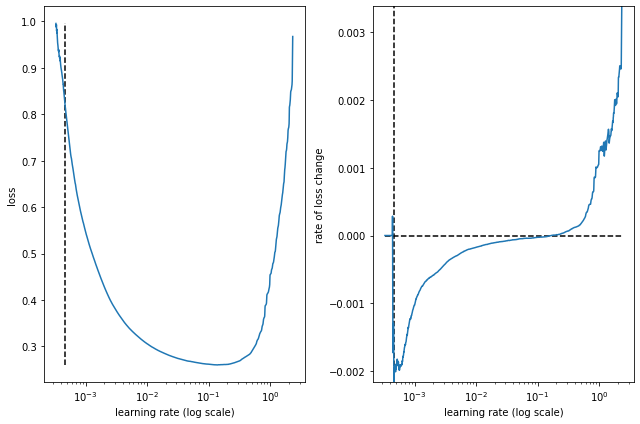

best lr: 0.000461542 

Model: "lstm_24l_96s_2m_s_d01"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_27 (LSTM)               (None, 24, 16)            1728      
_________________________________________________________________
lstm_28 (LSTM)               (None, 16)                2112      
_________________________________________________________________
dense_20 (Dense)             (None, 96)                1632      
Total params: 5,472
Trainable params: 5,472
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
17638/17638 - 197s - loss: 0.1434 - mae: 0.2884 - val_loss: 0.1936 - val_mae: 0.3373
Epoch 2/5
17638/17638 - 195s - loss: 0.1223 - mae: 0.2668 - val_loss: 0.1915 - val_mae: 0.3360
Epoch 3/5
17638/17638 - 192s - loss: 0.1186 - mae: 0.2621 - val_loss: 0.1909 - val_mae: 0.3347
Epoch 4/5
17638/17638 - 194s - loss: 0.1163 - mae: 0.2591 - val_l

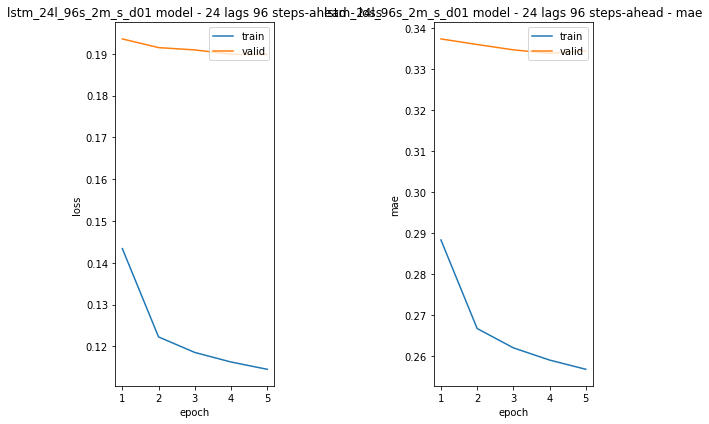

lstm_24l_96s_2m_s_d01 model - 24 lags 96 steps-ahead - train min loss: 0.114541	mae: 0.256855	epoch: 5
lstm_24l_96s_2m_s_d01 model - 24 lags 96 steps-ahead - valid min loss: 0.189843	mae: 0.334417	epoch: 5



In [58]:
def build_stacked_lstm_dropout_model(name, data, do = 0.0, rdo = 0.0, n_feature_maps = 8):
    in_shape, out_shape = get_io_shapes(data)
    out_steps = out_shape[0]

    lstm = Sequential(name = name)
    lstm.add(InputLayer(input_shape = in_shape))

    # Shape [batch, time, features] => [batch, n_feature_maps]
    lstm.add(LSTM(n_feature_maps,
                  return_sequences = True,
                  dropout = do,
                  recurrent_dropout = rdo))
    lstm.add(LSTM(n_feature_maps, dropout = do, recurrent_dropout = rdo))

    # Shape => [batch, out_steps]
    lstm.add(Dense(out_steps,
                   kernel_initializer = tf.initializers.zeros()))

    return lstm


models['lstm_24l_96s_2m_s_d01'] = build_stacked_lstm_dropout_model('lstm_24l_96s_2m_s_d01', 
                                                                   ds['train_24l_96s_2m'],
                                                                   0.1,
                                                                   0.0,
                                                                   feat_maps)
sum_params = [0.0003, 10, 32, 5, 100, 25]
lrf = run_lrf(models, ds['train_24l_96s_2m'],  'lstm_24l_96s_2m_s_d01',  lrf, sum_params)
h['lstm_24l_96s_2m_s_d01'] = run_model(models['lstm_24l_96s_2m_s_d01'], ds['train_24l_96s_2m'], ds['valid_24l_96s_2m'], epochs = 5)

Epoch 1/5
17638/17638 [==============================] - 42s 2ms/step - loss: 1.0607 - mae: 0.5715


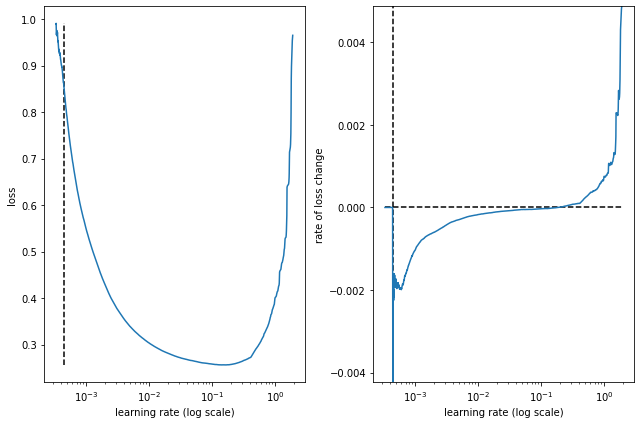

best lr: 0.0004394165 

Model: "lstm_24l_96s_2m_s_d01"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_29 (LSTM)               (None, 24, 16)            1728      
_________________________________________________________________
lstm_30 (LSTM)               (None, 16)                2112      
_________________________________________________________________
dense_21 (Dense)             (None, 96)                1632      
Total params: 5,472
Trainable params: 5,472
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
17638/17638 - 195s - loss: 0.1412 - mae: 0.2853 - val_loss: 0.1916 - val_mae: 0.3349
Epoch 2/5
17638/17638 - 191s - loss: 0.1198 - mae: 0.2633 - val_loss: 0.1905 - val_mae: 0.3341
Epoch 3/5
17638/17638 - 190s - loss: 0.1162 - mae: 0.2585 - val_loss: 0.1907 - val_mae: 0.3352
Epoch 4/5
17638/17638 - 193s - loss: 0.1139 - mae: 0.2555 - val_

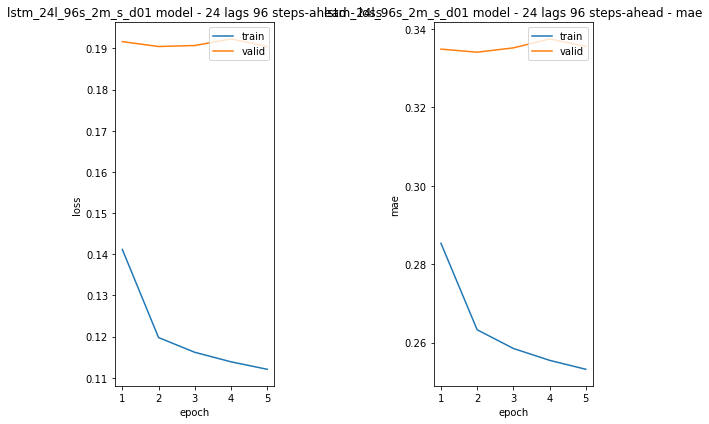

lstm_24l_96s_2m_s_d01 model - 24 lags 96 steps-ahead - train min loss: 0.112071	mae: 0.253185	epoch: 5
lstm_24l_96s_2m_s_d01 model - 24 lags 96 steps-ahead - valid min loss: 0.190453	mae: 0.334095	epoch: 2



In [59]:
def build_stacked_lstm_dropout_model(name, data, do = 0.0, rdo = 0.0, n_feature_maps = 8):
    in_shape, out_shape = get_io_shapes(data)
    out_steps = out_shape[0]

    lstm = Sequential(name = name)
    lstm.add(InputLayer(input_shape = in_shape))

    # Shape [batch, time, features] => [batch, n_feature_maps]
    lstm.add(LSTM(n_feature_maps,
                  return_sequences = True,
                  dropout = do,
                  recurrent_dropout = rdo))
    lstm.add(LSTM(n_feature_maps))

    # Shape => [batch, out_steps]
    lstm.add(Dense(out_steps,
                   kernel_initializer = tf.initializers.zeros()))

    return lstm


models['lstm_24l_96s_2m_s_d01'] = build_stacked_lstm_dropout_model('lstm_24l_96s_2m_s_d01', 
                                                                   ds['train_24l_96s_2m'],
                                                                   0.1,
                                                                   0.0,
                                                                   feat_maps)
sum_params = [0.0003, 10, 32, 5, 100, 25]
lrf = run_lrf(models, ds['train_24l_96s_2m'],  'lstm_24l_96s_2m_s_d01',  lrf, sum_params)
h['lstm_24l_96s_2m_s_d01'] = run_model(models['lstm_24l_96s_2m_s_d01'], ds['train_24l_96s_2m'], ds['valid_24l_96s_2m'], epochs = 5)

In [ ]:
def build_stacked_lstm_dropout_model(name, data, do = 0.0, rdo = 0.0, n_feature_maps = 8):
    in_shape, out_shape = get_io_shapes(data)
    out_steps = out_shape[0]

    lstm = Sequential(name = name)
    lstm.add(InputLayer(input_shape = in_shape))

    # Shape [batch, time, features] => [batch, n_feature_maps]
    lstm.add(LSTM(n_feature_maps,
                  return_sequences = True,
                  dropout = do,
                  recurrent_dropout = rdo))
    lstm.add(LSTM(n_feature_maps))

    # Shape => [batch, out_steps]
    lstm.add(Dense(out_steps,
                   kernel_initializer = tf.initializers.zeros()))

    return lstm


models['lstm_24l_96s_2m_s_rd01'] = build_stacked_lstm_dropout_model('lstm_24l_96s_2m_s_rd01', 
                                                                    ds['train_24l_96s_2m'],
                                                                    0.0,
                                                                    0.1,
                                                                    feat_maps)
sum_params = [0.0001, 10, 32, 5, 100, 25]
lrf = run_lrf(models, ds['train_24l_96s_2m'],  'lstm_24l_96s_2m_s_rd01',  lrf, sum_params)
h['lstm_24l_96s_2m_s_rd01'] = run_model(models['lstm_24l_96s_2m_s_rd01'], ds['train_24l_96s_2m'], ds['valid_24l_96s_2m'], epochs = 5)

Epoch 1/5
 1598/17638 [=>............................] - ETA: 32:33 - loss: 0.3229 - mae: 0.4239

...

---

### Check best model on test data

...

In [30]:
def plot_obs_preds(obs, preds, title):
    plt.figure(figsize = (12, 8))
    plt.subplot(3, 1, 1)
    plt.scatter(x = obs, y = preds)
    y_lim = plt.ylim()
    x_lim = plt.xlim()
    plt.plot(x_lim, y_lim, 'k-', color = 'grey')
    plt.xlabel('Observations')
    plt.ylabel('Predictions')
    plt.title(title)


def plot_residuals(obs, preds, title):
    plt.subplot(3, 1, 2)
    plt.scatter(x = range(len(obs)), y = (obs - preds))
    plt.axhline(y = 0, color = 'grey')
    plt.xlabel('Position')
    plt.ylabel('Residuals')
    plt.title(title)


def plot_residuals_dist(obs, preds, title):
    data = obs - preds
    plt.subplot(3, 1, 3)
    pd.Series(data).plot(kind = 'density')
    plt.axvline(x = 0, color = 'grey')
    plt.title(title)
    plt.tight_layout()
    plt.show()


def rmse(obs, preds):
    return np.sqrt(np.mean((obs - preds) ** 2))


def mae(obs, preds):
    return np.median(np.abs(obs - preds))


# From https://stackoverflow.com/a/62170887/100129
def inv_transform(scaler, data, colName, colNames):
    dummy = pd.DataFrame(np.zeros((len(data), len(colNames))), columns=colNames)
    dummy[colName] = data
    dummy = pd.DataFrame(scaler.inverse_transform(dummy), columns=colNames)
    return dummy[colName].values


def check_test_data(model, test, desc):
    preds = model.predict(test)
    obs   = np.concatenate([y for _, y in test], axis = 0)

    # reshape obs & preds
    label_len = obs.shape[0]
    preds_len = len(preds)
    # print("labels:", label_len)
    # print("preds:",  preds_len)
    # print("preds:",  preds.shape)
    # print("obs:",    obs.shape)
    assert label_len == preds_len

    # print("obs[0]:", obs.shape[0])
    # print("obs[1]:", obs.shape[1])
    preds_long = preds.reshape((obs.shape[0] * obs.shape[1]))
    test_long  = obs.reshape((obs.shape[0] * obs.shape[1]))

    # inverse transform using train mean & sd
    t_preds = inv_transform(scaler, preds_long, 'y', train_df.columns)
    t_obs   = inv_transform(scaler, test_long,  'y', train_df.columns)

    t_rmse = rmse(t_obs, t_preds)  # Need to treat 4 step ahead rmse & mae properly
    t_mae  =  mae(t_obs, t_preds)
    print("t rmse ", desc, ": ",  t_rmse, sep = '')
    print("t mae ",  desc, ":  ", t_mae,  sep = '')

    title = 'Inverse transformed test data\n' + desc
    plot_obs_preds(t_obs, t_preds, title)
    plot_residuals(t_obs, t_preds, title)
    plot_residuals_dist(t_obs, t_preds, title)
    print("\n\n")



...

t rmse LSTM 24l 1s 2m S: 0.528360601153357
t mae LSTM 24l 1s 2m S:  0.2582263735154231


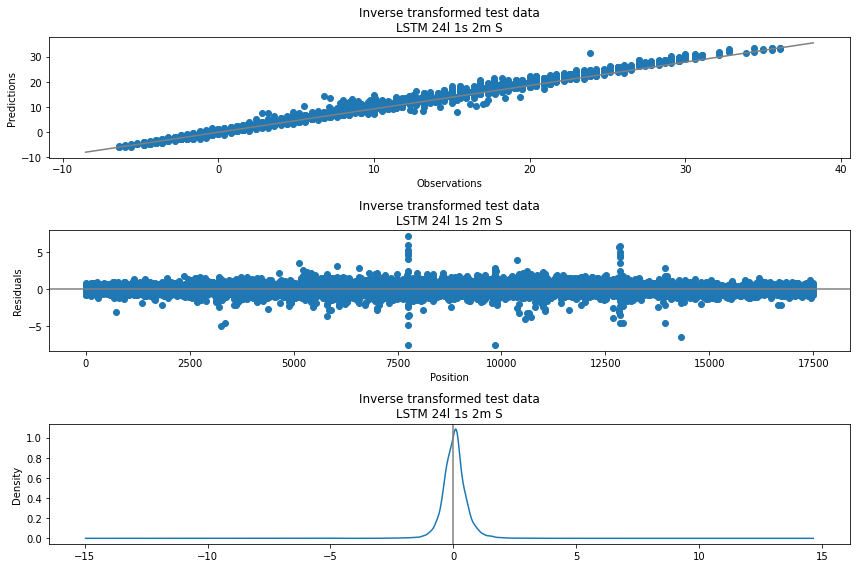




t rmse LSTM 24l 4s 2m S: 0.8015664892944987
t mae LSTM 24l 4s 2m S:  0.3938664868898867


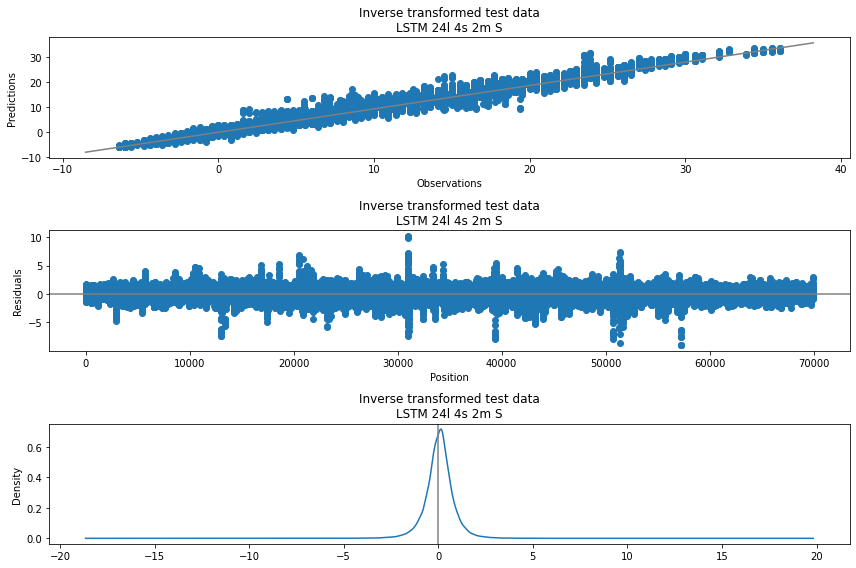




t rmse LSTM 24l 12s 2m S: 1.3077017951869967
t mae LSTM 24l 12s 2m S:  0.6633561106331602


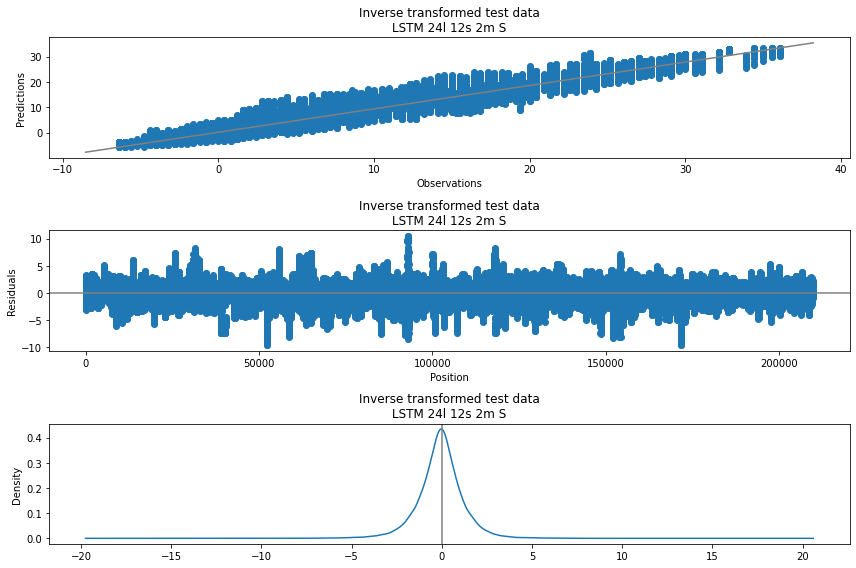




t rmse LSTM 24l 24s 2m S: 1.6927911472881778
t mae LSTM 24l 24s 2m S:  0.9155085104072018


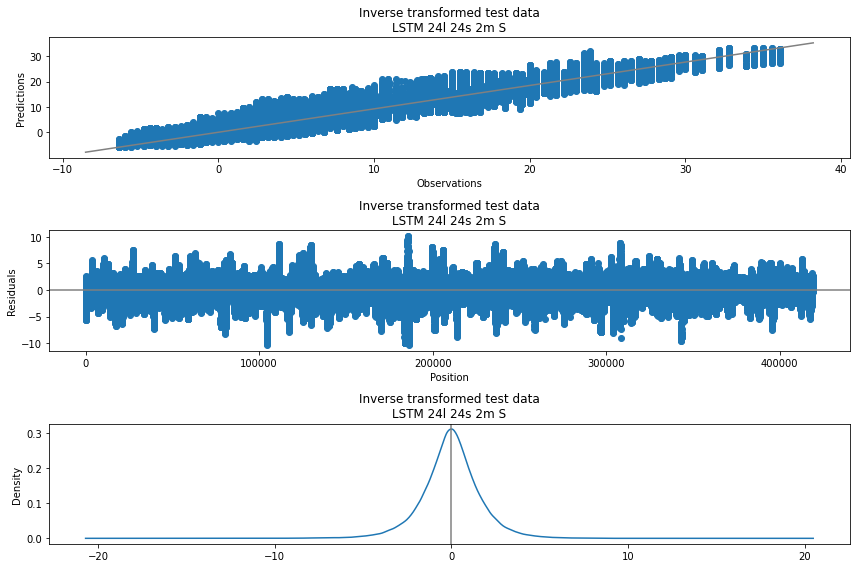




t rmse LSTM 24l 48s 2m S: 2.0898023030117523
t mae LSTM 24l 48s 2m S:  1.201144219741277


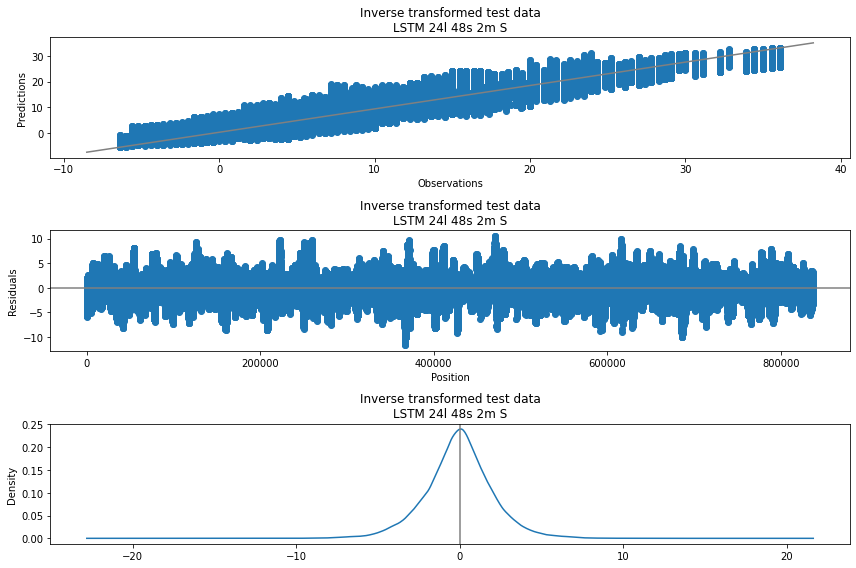




t rmse LSTM 24l 96s 2m S: 2.6083212591993976
t mae LSTM 24l 96s 2m S:  1.561261834000811


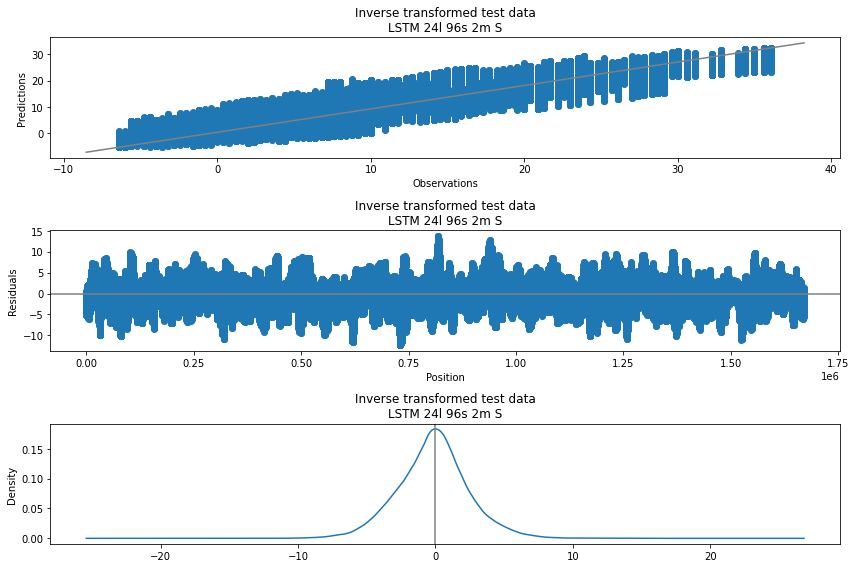

In [56]:
check_test_data(models['lstm_24l_1s_2m_s'],  ds['test_24l_1s_2m'],  'LSTM 24l 1s 2m S')
check_test_data(models['lstm_24l_4s_2m_s'],  ds['test_24l_4s_2m'],  'LSTM 24l 4s 2m S')
check_test_data(models['lstm_24l_12s_2m_s'], ds['test_24l_12s_2m'], 'LSTM 24l 12s 2m S')
check_test_data(models['lstm_24l_24s_2m_s'], ds['test_24l_24s_2m'], 'LSTM 24l 24s 2m S')
check_test_data(models['lstm_24l_48s_2m_s'], ds['test_24l_48s_2m'], 'LSTM 24l 48s 2m S')
check_test_data(models['lstm_24l_96s_2m_s'], ds['test_24l_96s_2m'], 'LSTM 24l 96s 2m S')

...

| h  | rmse | mae  |
|----|------|------|
|  1 | 0.53 | 0.26 |
|  4 | 0.8  | 0.39 |
| 12 | 1.31 | 0.66 |
| 24 | 1.69 | 0.91 |
| 48 | 2.09 | 1.2  |
| 96 | 2.61 | 1.56 |
 
...

---

### Test Time Augmentation

...

In [47]:
class TTA_ModelWrapper():
    """A TTA wrapper for keras time series models.
    Args:
        model: A fitted keras model with a predict method.
    """

    def __init__(self, model):
        self.model = model

    def predict(self, X):
        """Wraps the predict method of the provided model.
        Augments the test data with the mixup method and
        averages the results.
        Args:
            X: The data to get predictions for.
        """

        def tta_mixup(batch, alpha = 4.0):
            batch_mix = []
            for data in batch:
              data_size = len(data) - 1
    
              # random lambda value from beta distribution
              l   = np.random.beta(alpha, alpha, 1)
              X_l = np.repeat(l, data_size)
              X_l = X_l.reshape(data_size, 1)
    
              # Get a pair of outputs
              X1 = data[1:data_size + 1]    
              X2 = data[0:data_size]

              # Perform mixup
              X_mix = X1 * X_l + X2 * (1 - X_l)
              X_mix = np.vstack([X_mix, data[data_size]])
              batch_mix.append(X_mix)
    
            return np.array(batch_mix)

        mixups = 5  # 5 is an arbitrary value
        preds = []
        for x_i, _ in X.as_numpy_iterator():
          p = self.model.predict(x_i)
          for m in range(mixups):
            # p_m = self.model.predict(tta_mixup(x_i, alpha = (m + 1) * 1.0))
            p_m = self.model.predict(tta_mixup(x_i))
            p = p + p_m
          p = p / (mixups + 1)
          preds.append(p)

        return np.concatenate([p for p in np.array(preds)], axis = 0)


...

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


t rmse LSTM 24l 1s 2m S TTA: 0.5282361897824677
t mae LSTM 24l 1s 2m S TTA:  0.25553457775809596


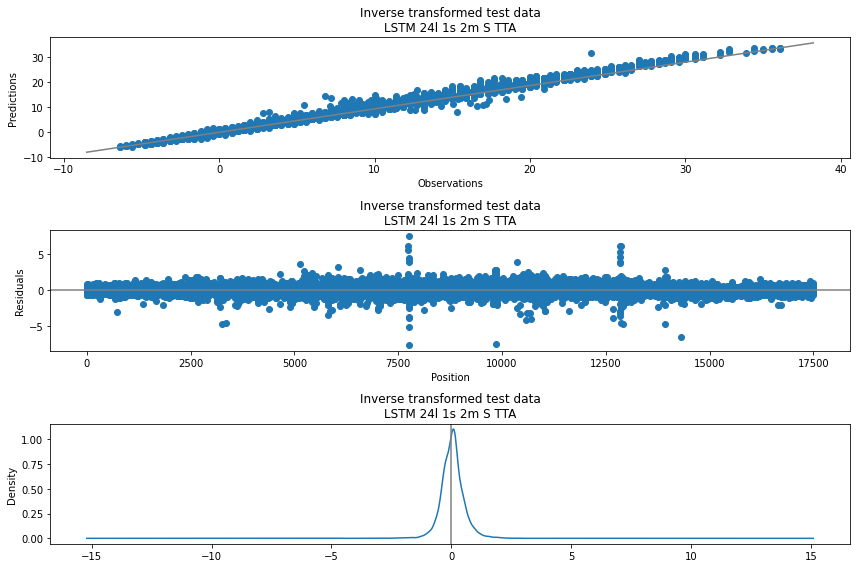

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


t rmse LSTM 24l 4s 2m S TTA: 0.8088822676954985
t mae LSTM 24l 4s 2m S TTA:  0.39845011894932414


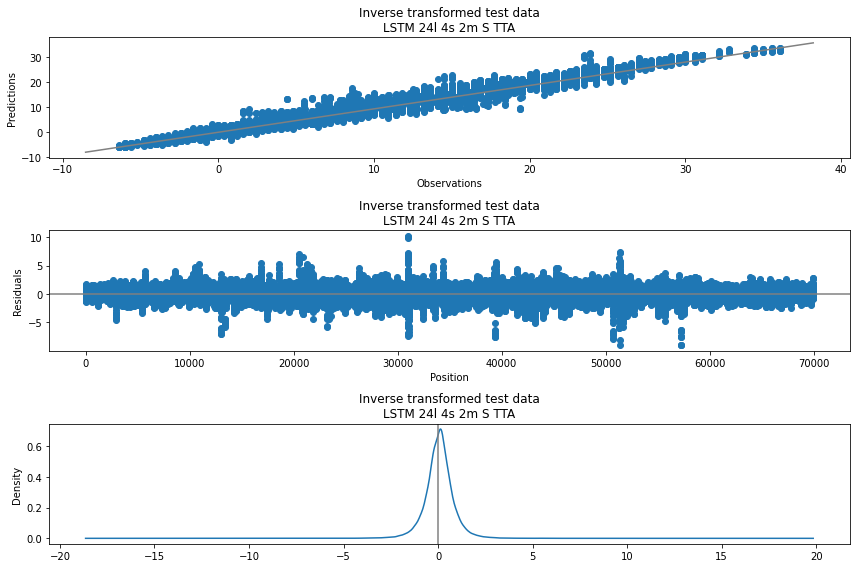

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


t rmse LSTM 24l 48s 2m S TTA: 2.098152969528931
t mae LSTM 24l 48s 2m S TTA:  1.2099365118827379


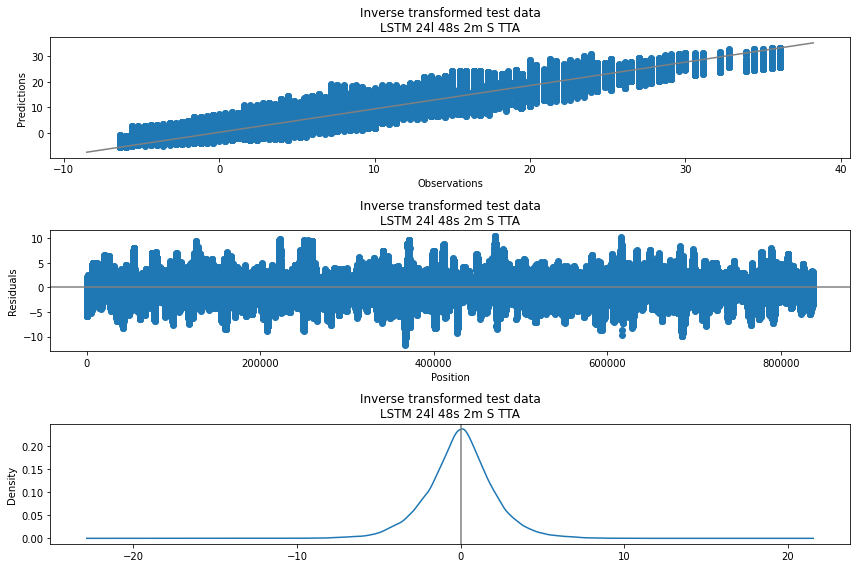

In [48]:
models['lstm_24l_1s_2m_tta']  = TTA_ModelWrapper(models['lstm_24l_1s_2m_s'])
models['lstm_24l_4s_2m_tta']  = TTA_ModelWrapper(models['lstm_24l_4s_2m_s'])
models['lstm_24l_48s_2m_tta'] = TTA_ModelWrapper(models['lstm_24l_48s_2m_s'])

check_test_data(models['lstm_24l_1s_2m_tta'],  ds['test_24l_1s'],  'LSTM 24l 1s 2m S TTA')
check_test_data(models['lstm_24l_4s_2m_tta'],  ds['test_24l_4s'],  'LSTM 24l 4s 2m S TTA')
check_test_data(models['lstm_24l_48s_2m_tta'], ds['test_24l_48s'], 'LSTM 24l 48s 2m S TTA')

...

---

### Comparison with baselines

...

...

---


## Conclusion

Fortunately, ...

On an unrealted matter, ...

Future work:
 * ...
 * Further optimise model and data parameters
   * Lags
     * {1-24, 1-48} plus zero or more of {48, 96, 144, 192, 240, 288, 336}
   * Selective application of mixup
     * Apply mixup augmentation to some of the variables instead of all of them
   * ...
 * ...
 * Additional architectures to examine
   * [ConvLSTM1D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/ConvLSTM2D) Keras 1D Convolutional LSTM  (input transformations and recurrent transformations are both convolutional) which includes support for [dilated convolution](https://towardsdatascience.com/understanding-2d-dilated-convolution-operation-with-examples-in-numpy-and-tensorflow-with-d376b3972b25)
     * as of 12/07/21 only available in tf-nightly :-(
   * [Gated Residual and Variable Selection Networks](https://keras.io/examples/structured_data/classification_with_grn_and_vsn/)
     * GRNs apply non-linear processing only when necessary
     * VSNs can remove noisy inputs
   * [TFT - Temporal Fusion Transformers](https://arxiv.org/abs/1912.09363) which is an attention based architecture which can provide interpretable insights into temporal dynamics - GRNs and VSNs were proposed in the TFT paper
   * [ConvLSTM2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/ConvLSTM2D) Keras 2D Convolutional LSTM layer - thought to perform well for weather forecasting where inputs are timeseries of 2D grids of sensor values
     * not directly relevant for the data used in this notebook
     * requires additional data from [ISD](https://www.ncdc.noaa.gov/isd) and/or other [NOAA sources](https://www.ncdc.noaa.gov/data-access/land-based-station-data/land-based-datasets)
     * [Keras conv LSTM tutorial](https://keras.io/examples/vision/conv_lstm/)
 * ...

---

## Metadata

Python and Jupyter versions plus modules imported and their version strings. 
This is the poor man's python equivalent of R's sessionInfo().

Code for imported modules and versions adapted from this stackoverflow answer. 
There are simpler alternatives, such as watermark, but they all require installation.

In [ ]:
import sys
import IPython

print("Python version:")
print(sys.executable)
print(sys.version)
print("\nIPython version:")
print(IPython.__version__)

Python version:
/usr/bin/python3
3.7.10 (default, Feb 20 2021, 21:17:23) 
[GCC 7.5.0]

IPython version:
5.5.0


In [ ]:
import pkg_resources
import types

def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            # Split ensures you get root package, 
            # not just imported function
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):
            name = val.__module__.split(".")[0]

        # Some packages are weird and have different
        # imported names vs. system/pip names.  Unfortunately,
        # there is no systematic way to get pip names from
        # a package's imported name.  You'll have to add
        # exceptions to this list manually!
        poorly_named_packages = {
            "PIL":       "Pillow",
            "sklearn":   "scikit-learn",
        }
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]

        yield name

imports = list(set(get_imports()))

# The only way I found to get the version of the root package
# from only the name of the package is to cross-check the names 
# of installed packages vs. imported packages
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name != "pip":
        requirements.append((m.project_name, m.version))

reqs = pd.DataFrame(requirements, columns = ['name', 'version'])
print("Imported modules:")
reqs.style.hide_index()

Imported modules:


name,version
statsmodels,0.10.2
pandas,1.1.5
numpy,1.19.5
matplotlib,3.2.2


In [ ]:
!lscpu

In [ ]:
!date

Thu Apr 22 20:52:55 UTC 2021


---


## Archival

Archive code, markdown, history and formatted notebooks.

Assumes all pdf, html, latex etc dependencies are installed.

**WARNING** Will overwrite existing files.

Notebook name is hardcoded below because the alternative is ghastly globs of unreliable javascript or external ipython libraries I'd prefer to avoid installing :-(

In [ ]:
from time import sleep

notebook = "cammet_baselines_2021.ipynb"
# !jupyter nbconvert --to script {notebook}
# !jupyter nbconvert --execute --to html {notebook}
# !jupyter nbconvert --execute --to pdf {notebook}
# !jupyter nbconvert --to pdf {notebook}

%rm history.txt
%history -f history.txt

!jupyter nbconvert --to python {notebook}
sleep(5)
!jupyter nbconvert --to markdown {notebook}
sleep(5)
!jupyter nbconvert --to html {notebook}